# IAU - Inteligentná analýza údajov (2024/2025)

#### Autori: Jan Lenhart (50 %), Marek Čederle (50 %)
##### Cvičenie: Pondelok 15:00, Cvičiaci: Ing. Oleksandr Lytvyn

<font color='salmon'>
    <b>Poznámka:</b>
    Fáza 1 - boli zachované nejaké časti, funkcie a knižnice, ktoré nám boli užitočné pri fáze 2, pri prezeraní fázy 2 je vhodné si fázu 1 zbaliť
</font>

## Fáza 1 - Prieskumná analýza

Na začiatok si importujeme knižnice a načítame dáta, do dátových rámcov (dataframov).

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from scipy import stats
import statsmodels.api as sm

In [2]:
pd.set_option("display.width", 2**20)
pd.set_option("display.max_columns", 32)

In [3]:
df_connections = pd.read_csv('112/connections.csv', delimiter=',')
df_processes   = pd.read_csv('112/processes.csv', delimiter=',')

IMEI je unikátny identifikátor mobilného zariadenia, ktorý sa nachádza vo všetkých rámcoch, takže ho bude možné použiť ako primárny kľúč na spájanie tabuliek, ak to bude neskôr potrebné.

In [4]:
def print_normality_test(df):
    if df.count() > 5000:
        stat, p_value = stats.kstest(df, 'norm')
        print(f"kstest for count={df.count()}: [stat: {stat}, p: {p_value}, norm: {p_value > 0.05}]")
    else:
        stat, p_value = stats.shapiro(df)
        print(f"stat: for count={df.count()}: [stat: {stat}, p: {p_value}, norm: {p_value > 0.05}]")

In [5]:
print_normality_test(df_connections["c.katana"])
print_normality_test(df_connections["c.android.gm"])
print_normality_test(df_connections["c.android.chrome"])
print_normality_test(df_connections["c.dogalize"])

kstest for count=15126: [stat: 0.9996854614716099, p: 0.0, norm: False]
kstest for count=15126: [stat: 0.999268481364025, p: 0.0, norm: False]
kstest for count=15126: [stat: 0.9985923997727452, p: 0.0, norm: False]
kstest for count=15126: [stat: 0.9991679161054106, p: 0.0, norm: False]


Počet záznamov je väčší ako 5000, preto bol použitý Kolmogorov-Smirnov (`kstest`) namiesto Shapiro-Wilk z ktorého vyplíva, že dáta vo vybraných stĺpcoch nespĺňajú normálovú distribúciu pretože p-hodnota je menšia ako 0.05.

In [6]:
print_normality_test(df_processes["p.android.gm"])
print_normality_test(df_processes["p.system"])
print_normality_test(df_processes["p.android.chrome"])
print_normality_test(df_processes["p.browser.provider"])
print_normality_test(df_processes["p.android.documentsui"])
print_normality_test(df_processes["p.android.packageinstaller"])


kstest for count=15126: [stat: 0.999621449898638, p: 0.0, norm: False]
kstest for count=15126: [stat: 0.9993553758048951, p: 0.0, norm: False]
kstest for count=15126: [stat: 0.9998378290984429, p: 0.0, norm: False]
kstest for count=15126: [stat: 0.5000216559694981, p: 0.0, norm: False]
kstest for count=15126: [stat: 0.9998194899263412, p: 0.0, norm: False]
kstest for count=15126: [stat: 0.9998867740277617, p: 0.0, norm: False]


In [7]:
target_predictor = 'mwra'
strong_predictors = pd.DataFrame()
moderate_predictors = pd.DataFrame()
weak_predictors = pd.DataFrame()

In [8]:
def numerical_prediction(df):
    global strong_predictors, moderate_predictors, weak_predictors
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
    corr_matrix = df[numerical_columns].corr()
    corrs = corr_matrix[[target_predictor]].sort_values(by=target_predictor, ascending=False)
    corrs = corrs.drop('mwra')
    sns.heatmap(corrs, annot=True, cmap='coolwarm')
    plt.title(f'Correlation of {target_predictor} with numerical predictors')
    plt.show()
    strong_predictors = pd.concat([strong_predictors, pd.DataFrame(np.where(abs(corrs) > 0.7, corrs, np.nan), columns=corrs.columns, index=corrs.index).dropna()])
    moderate_predictors = pd.concat([moderate_predictors, pd.DataFrame(np.where((abs(corrs) > 0.5) & (abs(corrs) <= 0.7), corrs, np.nan), columns=corrs.columns, index=corrs.index).dropna()])
    weak_predictors = pd.concat([weak_predictors, pd.DataFrame(np.where((abs(corrs) > 0.25) & (abs(corrs) <= 0.5), corrs, np.nan), columns=corrs.columns, index=corrs.index).dropna()])

Funkcia `numerical_prediction` získa prediktory pre dátový rámec, ktorý dostane ako parameter. Získané prediktory akumuluje do globálnych premenných `strong_predictors`, `moderate_predictors` a `weak_predictors`. To sú kategorizované premenné, ktoré v páre so stĺpcom `mwra` majú koreláciu viac ako `0.7` pre `strong`, viac ako `0.5` a menej ako `0.7` pre `moderate` a viac ako `0.25` (bolo by lepšie, keby toto číslo bolo 0.3, ale chceli sme zvýšiť počet prediktorov a ak budú dávať zlé výsledky, môžeme ich kedykoľvek vyhodiť) a menej ako `0.5` pre `weak`. Taktiež, pri volaní zobrazí heatmapu vypočítaných korelácií, aby poskytla vizuálny prehľad o vzťahoch medzi premennými.

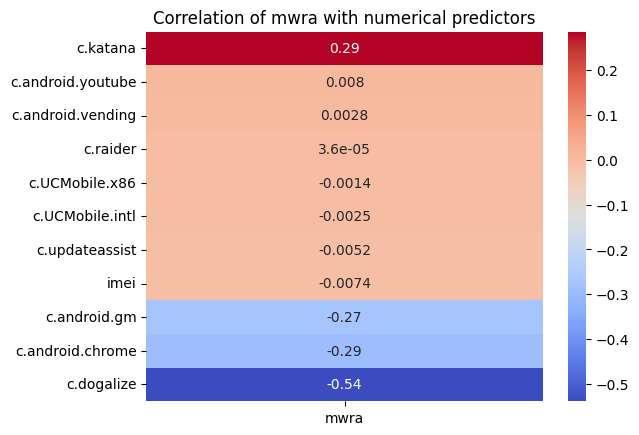

In [9]:
numerical_prediction(df_connections)

Tento graf nám hovorí o tom, ktoré premenné z dátového rámca `df_connections` korelujú s našou predikovanou premennou `mwra`.
Môžeme vidieť že stĺpce `c.dogalize`, `c.android.chrome` a `c.katana` majú najvyššiu koreláciu s predikovanou premennou `mwra`.

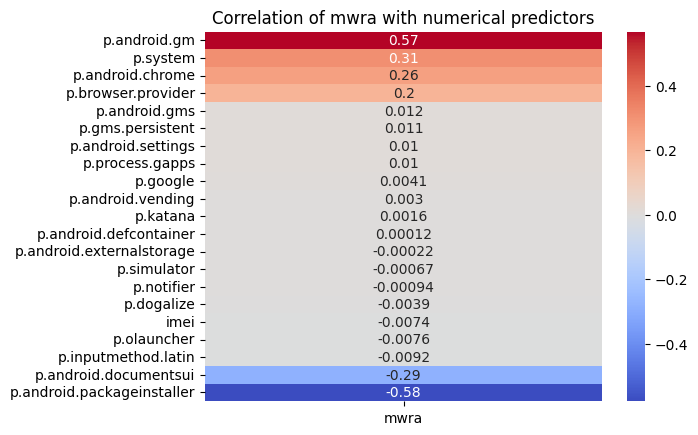

In [10]:
numerical_prediction(df_processes)

Tento graf nám hovorí o tom, ktoré premenné z dátového rámca `df_processes` korelujú s našou predikovanou premennou `mwra`.
Môžeme vidieť že stĺpce `p.android.gm`, `p.system`, `p.android.chrome`, `p.android.documentsui` a `p.android.packageinstaller` majú najvyššiu koreláciu s predikovanou premennou `mwra`.

In [11]:
print(strong_predictors)

Empty DataFrame
Columns: [mwra]
Index: []


In [12]:
print(moderate_predictors)

                                mwra
c.dogalize                 -0.538271
p.android.gm                0.567423
p.android.packageinstaller -0.579099


In [13]:
print(weak_predictors)

                           mwra
c.katana               0.285185
c.android.gm          -0.271405
c.android.chrome      -0.294828
p.system               0.310021
p.android.chrome       0.260711
p.android.documentsui -0.285944


Tu môžeme vidieť že nemáme žiadne silné predikátory (korelácia `> 0.7`).
Máme však stredne silné a slabšie predikátory.

#### 1.1.E Zamyslenie k riešeniu projektu

Pomocou párovej analýzi sme zistili nejakú koreláciu resp. závisloť premenných. Konkrétne mali najsilnejšiu koreláciu s predikovanou premennou `mwra` tieto stĺpce:
- c.dogalize
- p.android.gm
- p.android.packageinstaller

Kedže sa nachádzajú v iných dátových rámcoch, bude potrebné ich spojiť pomocou `imei`.

Podľa toho, ako dáta vyzerajú a čo sme zistili, tak si myslíme že ide o nejaké využitie CPU s tým že CPU môže mať viacero jadier a preto hodnoty premenných nedávajú súčet 100 ale viacej čo by znamenalo že by mohlo ísť o viacej jadrové CPU (napr. 8), ale toto je iba naša teória.

Je vysoko pravdepodobné že bude treba spájať dané dáta pretože aj `devices.csv` aj `processes.csv` majú stĺpec `mwra` a budeme muset zistit koreláciu naprieč týmito dátami.

### 1.2 Identifikácia problémov, integrácia a čistenie dát

#### 1.2.A Identifikácia a prvotné riešenie problémov v dátach

In [14]:
connections_string_columns = set(copy(df_connections.select_dtypes(include=['object']).columns))
processes_string_columns = set(copy(df_processes.select_dtypes(include=['object']).columns))
string_columns = list(connections_string_columns | processes_string_columns)
print(string_columns)

['ts']


##### Vymazanie duplikátov v dátach

In [15]:
def remove_duplicates(df):
    pre_count = df.duplicated().count()
    df = df.drop_duplicates()
    post_count = df.duplicated().count()
    print(f"removed {pre_count - post_count} duplicates")
    return df

In [16]:
df_connections = remove_duplicates(df_connections)

removed 179 duplicates


In [17]:
df_processes = remove_duplicates(df_processes)

removed 179 duplicates


#### 1.2.B Chýbajúce hodnoty (missing values)

In [18]:
def printNonesAndNA(label, df):
    nulls = df.isnull().sum()
    if (nulls.sum()):
        df_temp = pd.DataFrame(np.where(nulls > 0, nulls, np.nan), index=nulls.index, columns=['null_count']).dropna()
        df_temp['percentage'] = df_temp.apply(lambda x: x / df.shape[0] * 100)
        print(label)
        print(df_temp)
        print()
        return df_temp

In [19]:
printNonesAndNA("df_connections", df_connections)
printNonesAndNA("df_processes", df_processes)

#### 1.2.C Vychýlené hodnoty (outlier detection)

Na ukážku si vykreslíme boxploty pre vybrané atribúty a zistíme, či sa v nich nachádzajú nejaké vychýlené hodnoty. Naše atribúty sú premenné, ktoré najviac korelovali s predikovanou premennou `mwra` a teda sú to:
- c.dogalize
- p.android.gm
- p.android.packageinstaller

<Axes: xlabel='mwra', ylabel='c.dogalize'>

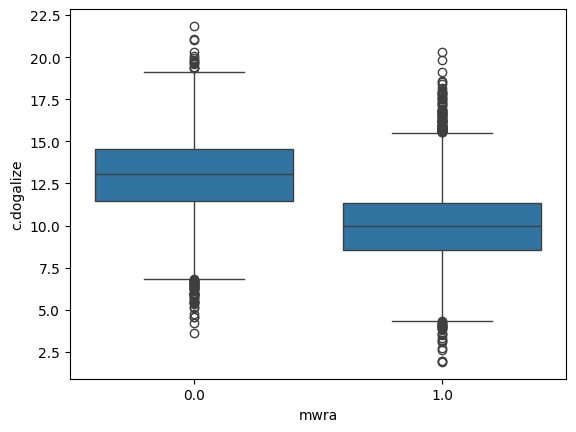

In [20]:
sns.boxplot(x='mwra', y='c.dogalize', data=df_connections)

<Axes: xlabel='mwra', ylabel='p.android.gm'>

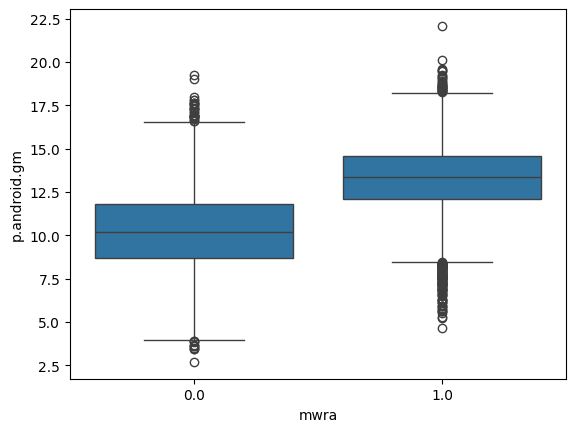

In [21]:
sns.boxplot(x='mwra', y='p.android.gm', data=df_processes)

<Axes: xlabel='mwra', ylabel='p.android.packageinstaller'>

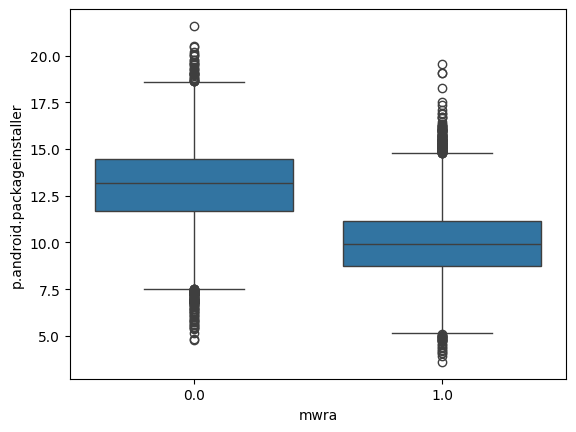

In [22]:
sns.boxplot(x='mwra', y='p.android.packageinstaller', data=df_processes)

Následne identifikujeme outlierov pomocou IQR metódy a overíme že ich skutočne máme.

In [23]:
# zdroj z cvicenia
def identify_outliers(data):
    lower = data.quantile(0.25) - 1.5 * stats.iqr(data)
    upper = data.quantile(0.75) + 1.5 * stats.iqr(data)
    return data[(data > upper) | (data < lower)]

In [24]:
def identify_outliers_for_all_columns(df):
    val = {}
    columns = df.select_dtypes(exclude=['object']).columns
    for column in columns:
        outlier_count = identify_outliers(df[column]).count()
        if outlier_count > 0:
            val[column] = outlier_count
    return val

In [25]:
identify_outliers_for_all_columns(df_connections)

{'c.android.youtube': np.int64(17),
 'c.katana': np.int64(97),
 'c.dogalize': np.int64(51),
 'c.android.chrome': np.int64(100),
 'c.android.gm': np.int64(47),
 'c.raider': np.int64(111),
 'c.UCMobile.x86': np.int64(91)}

In [26]:
identify_outliers_for_all_columns(df_processes)

{'p.system': np.int64(9),
 'p.android.chrome': np.int64(245),
 'p.android.settings': np.int64(146),
 'p.android.gm': np.int64(63),
 'p.android.packageinstaller': np.int64(59),
 'p.android.externalstorage': np.int64(22),
 'p.android.documentsui': np.int64(28),
 'p.simulator': np.int64(98),
 'p.browser.provider': np.int64(1895),
 'p.gms.persistent': np.int64(121),
 'p.android.gms': np.int64(92)}

Zistili sme že ich máme relatívne málo vzhľadom na počet záznamov, takže ich môžeme odstrániť.

In [27]:
def remove_outliers_for_all_columns(df):
    df_temp = df.copy()
    indices = pd.DataFrame({})
    accumulated_indices = set()
    for column in df_temp.select_dtypes(exclude=['object']).columns:
        accumulated_indices |= set(identify_outliers(df_temp[column]).index)
    df_temp = df_temp.drop(accumulated_indices)
    return df_temp

In [28]:
df_connections = remove_outliers_for_all_columns(df_connections)
df_processes = remove_outliers_for_all_columns(df_processes)

Ostránime iba outlierov z dátového rámca `df_processes` a `df_connections` pretože, v dátovom rámci `df_devices` a `df_profiles` nemáme žiadne numerické hodnoty, s ktorými je vhodné pracovať. (Zemepisné súradnice a unikátne identifikátory)
Po odstránení outlierov si možeme znova identifikovať či náhodou nejakých ešte nemáme.

In [29]:
identify_outliers_for_all_columns(df_connections)

{'c.android.youtube': np.int64(1),
 'c.katana': np.int64(14),
 'c.dogalize': np.int64(5),
 'c.android.chrome': np.int64(11),
 'c.raider': np.int64(8),
 'c.UCMobile.x86': np.int64(6)}

In [30]:
identify_outliers_for_all_columns(df_processes)

{'p.system': np.int64(9),
 'p.android.gm': np.int64(7),
 'p.android.packageinstaller': np.int64(1),
 'p.android.externalstorage': np.int64(18),
 'p.android.documentsui': np.int64(17),
 'p.simulator': np.int64(8),
 'p.browser.provider': np.int64(1314),
 'p.gms.persistent': np.int64(6),
 'p.android.gms': np.int64(3)}

Zistili sme že napriek úvodnému odstráneniu mám stále outlierov. Deje sa to z toho dôvodu, že sa vlastne distibúcia posunie a preto sa nám objavili nový outliery. Keby takto pokračujeme a odstraňujeme stále dáta, tak by sme prišli o veľký počet záznamov a preto sme sa rozhodli ich nahradiť hraničnými hodnotami (5% a 95%).

<Axes: xlabel='mwra', ylabel='p.browser.provider'>

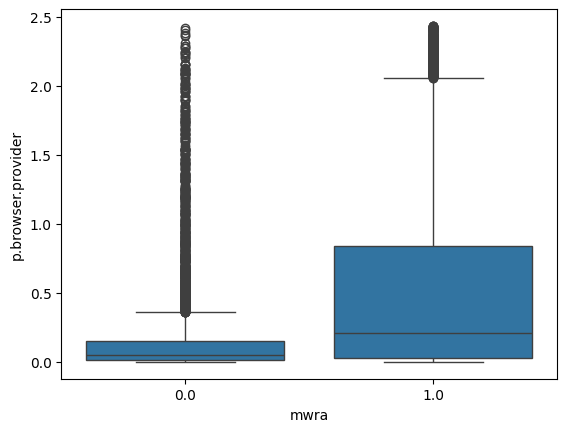

In [31]:
sns.boxplot(x='mwra', y='p.browser.provider', data=df_processes)

<Axes: xlabel='p.browser.provider', ylabel='Count'>

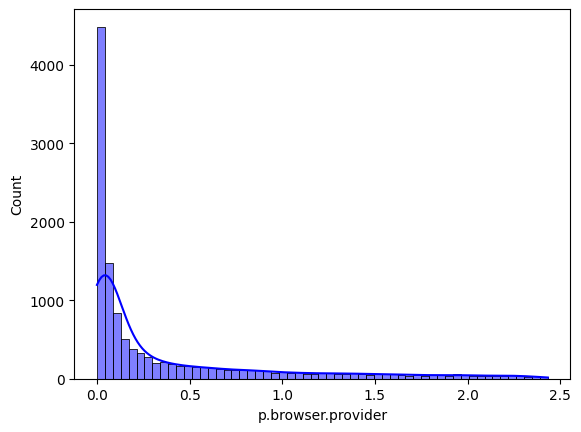

In [32]:
sns.histplot(df_processes['p.browser.provider'], kde=True, color='blue')

In [33]:
def replace_outliers_with_percentiles(df):
    df_temp = df.copy()
    for column in df_temp.select_dtypes(exclude=['object']).columns:
        lower_bound = df_temp[column].quantile(0.05)
        upper_bound = df_temp[column].quantile(0.95)
        lower_outliers = df_temp[column] < lower_bound
        upper_outliers = df_temp[column] > upper_bound
        df_temp.loc[lower_outliers, column] = lower_bound
        df_temp.loc[upper_outliers, column] = upper_bound
    return df_temp

In [34]:
df_connections = replace_outliers_with_percentiles(df_connections)
df_processes = replace_outliers_with_percentiles(df_processes)

In [35]:
identify_outliers_for_all_columns(df_connections)

{}

In [36]:
identify_outliers_for_all_columns(df_processes)

{'p.browser.provider': np.int64(1314)}

<Axes: xlabel='p.browser.provider', ylabel='Count'>

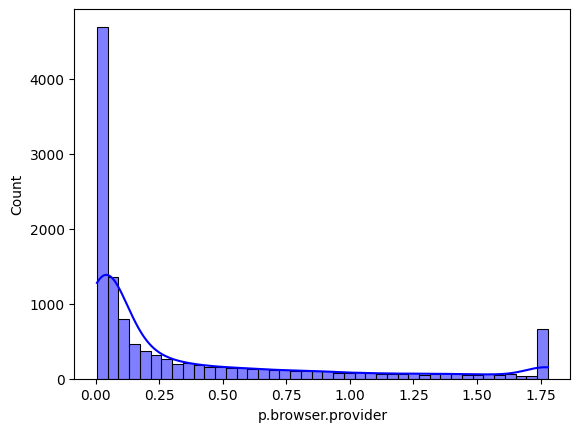

In [37]:
# histogram
sns.histplot(df_processes['p.browser.provider'], kde=True, color='blue')

Ako vidíme z výpisu dát, tak sa nám podarilo všetkých outlierov bud odstrániť alebo nahradiť hraničnými hodnotami.
Jedniou výnimkou je `p.browser.provider` a to z dôvodu ako vyzerá jeho distribúcia. Preto sme sa rozhodli to nemeniť, pretože by sme pri iteratívnom odstraňovaní prišli o veľký počet záznamov.

### 1.3 Formulácia a štatistické overenie hypotéz o dátach

#### 1.3.A Formulácia hypotéz

##### Hypotéza č.1

Zvolíme si náš "significance level" na $\alpha = 0.05$. (95%)

Null hypothesis (nulová hypotéza):

$H_0$: Premenná `p.android.gm` má v priemere rovnakú váhu v stave malware-related-activity ako v normálnom stave.

Alternative hypothesis (alternatívna hypotéza):
$H_1$ = $H_A$: Premenná `p.android.gm` má v priemere inú váhu v stave malware-related-activity ako v normálnom stave. (Nižšiu alebo vyššiu)

**Najskôr si musíme overiť či dáta spĺňajú normálovú distribúciu**

Takto vyzerá náš boxplot, ktorý nám ukazuje distribúciu hodnôt pre premennú `p.android.gm` v závislosti od `mwra`.

<Axes: xlabel='mwra', ylabel='p.android.gm'>

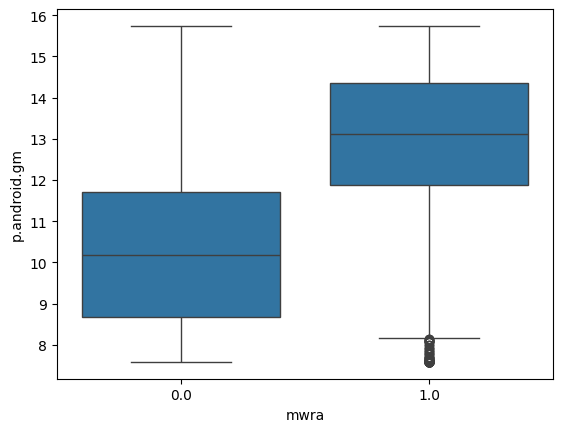

In [38]:
sns.boxplot(x='mwra', y='p.android.gm', data=df_processes)

In [39]:
p_android_gm_0 = df_processes.loc[df_processes.mwra == 0, 'p.android.gm']
p_android_gm_0.describe()

count    5047.000000
mean       10.347076
std         2.048929
min         7.582639
25%         8.662830
50%        10.168060
75%        11.699200
max        15.739069
Name: p.android.gm, dtype: float64

<Axes: xlabel='p.android.gm', ylabel='Count'>

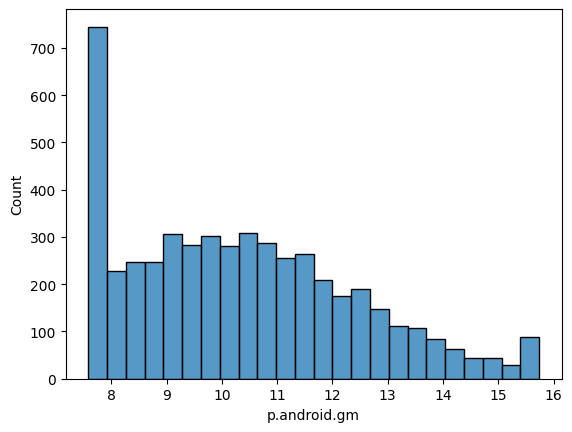

In [40]:
sns.histplot(p_android_gm_0)

In [41]:
p_android_gm_1 = df_processes.loc[df_processes.mwra == 1, 'p.android.gm']
p_android_gm_1.describe()

count    7217.000000
mean       13.023829
std         1.793842
min         7.582639
25%        11.879360
50%        13.119220
75%        14.359350
max        15.739069
Name: p.android.gm, dtype: float64

<Axes: xlabel='p.android.gm', ylabel='Count'>

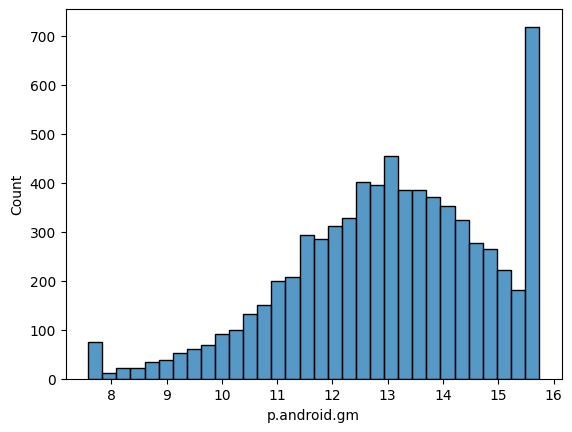

In [42]:
sns.histplot(p_android_gm_1)

Z týchto distribúcií môžeme vidieť, že nevyzerajú ako normálne distribúcie, preto musíme pokračovať s overením.

In [43]:
p_android_gm_0_outliers = identify_outliers(p_android_gm_0)
p_android_gm_1_outliers = identify_outliers(p_android_gm_1)

In [44]:
p_android_gm_0_outliers.count()

np.int64(0)

In [45]:
p_android_gm_1_outliers.count()

np.int64(91)

In [46]:
p_android_gm_0 = p_android_gm_0.drop(p_android_gm_0_outliers.index)
p_android_gm_1 = p_android_gm_1.drop(p_android_gm_1_outliers.index)

<Axes: xlabel='p.android.gm', ylabel='Count'>

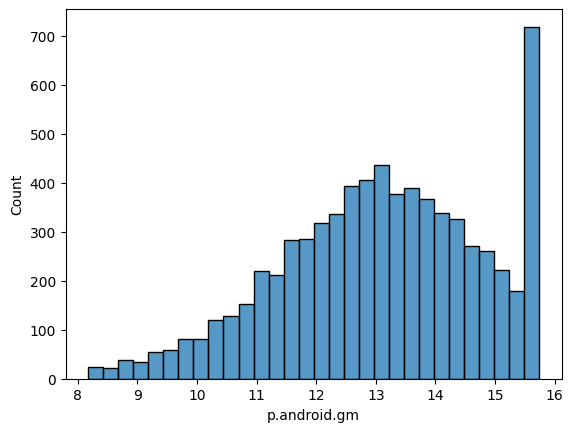

In [47]:
sns.histplot(p_android_gm_1)

Vidíme že aj po vyhodení outlierov sa nám distribúcia nezmenila a preto môžeme pokračovať s testovaním.

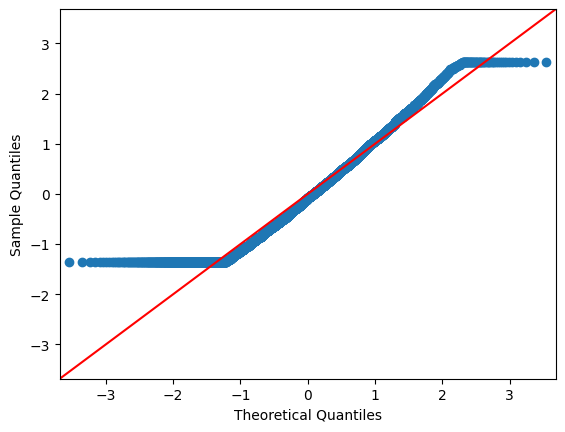

In [48]:
_ = sm.ProbPlot(p_android_gm_0, fit=True).qqplot(line='45')

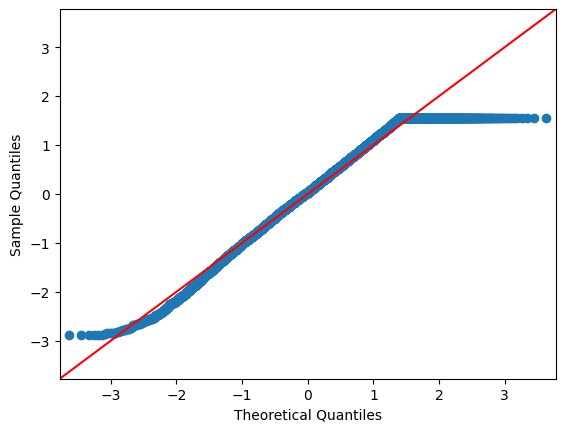

In [49]:
_ = sm.ProbPlot(p_android_gm_1, fit=True).qqplot(line='45')


Ani `QQ-plot` nám nepotvrdil normálnu distribúciu. Pretože aby bola distribúcia normálna, tak by sa body museli nachádzať na priamke definovanej ako $x=y$.

In [50]:
p_android_gm_0.count()

np.int64(5047)

In [51]:
p_android_gm_1.count()

np.int64(7126)

Musíme použiť štatistický test, ktorý nám povie či dáta majú normálnu distribúciu alebo nie. Použijeme `Kolmogorov-Smirnov` test namiesto `Shapiro-Wilk` pretože počet záznamov je väčší ako 5000.

In [52]:
print_normality_test(p_android_gm_0)

kstest for count=5047: [stat: 0.9999999999999831, p: 0.0, norm: False]


In [53]:
print_normality_test(p_android_gm_1)

kstest for count=7126: [stat: 0.9999999999999999, p: 0.0, norm: False]


Výsledok testu nám potvrdil, že dáta nemajú normálnu distribúciu, preto musíme použiť neparametrický test na overenie hypotézy. Pretože p hodnota je menšia ako 0.05.

Použijeme `Mann-Whitney U Test` pretože máme práve dve premenné a zároveň spĺňajú predpoklady pre tento test (vzorka musí byť aspoň 20).

In [54]:
stats.mannwhitneyu(p_android_gm_0, p_android_gm_1)

MannwhitneyuResult(statistic=np.float64(5688450.0), pvalue=np.float64(0.0))

Keďže nám vyšlo p menšie ako 0.05 tak zamietame nulovú hypotézu a prijímame alternatívnu hypotézu, že premenná `p.android.gm` má v priemere inú váhu v stave malware-related-activity ako v normálnom stave.

##### Hypotéza č.2

Zvolíme si náš "significance level" na $\alpha = 0.05$. (95%)

Null hypothesis (nulová hypotéza):

$H_0$: Premenná `p.android.packageinstaller` má v priemere rovnakú váhu v stave malware-related-activity ako v normálnom stave.

Alternative hypothesis (alternatívna hypotéza):
$H_1$ = $H_A$: Premenná `p.android.packageinstaller` má v priemere inú váhu v stave malware-related-activity ako v normálnom stave. (Nižšiu alebo vyššiu)

**Najskôr si musíme overiť či dáta spĺňajú normálovú distribúciu**

Takto vyzerá náš boxplot, ktorý nám ukazuje distribúciu hodnôt pre premennú `p.android.packageinstaller` v závislosti od `mwra`.

<Axes: xlabel='mwra', ylabel='p.android.packageinstaller'>

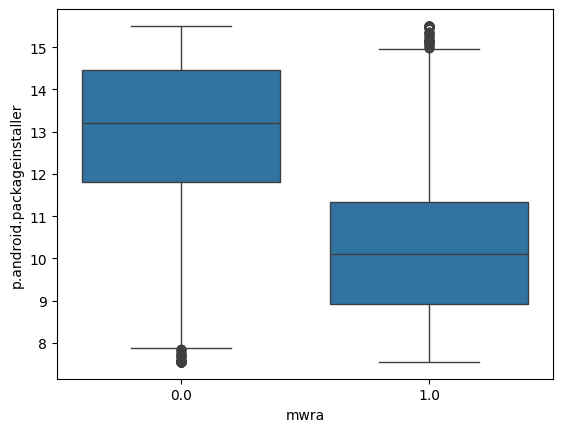

In [55]:
sns.boxplot(x='mwra', y='p.android.packageinstaller', data=df_processes)

In [56]:
p_android_packageinstaller_0 = df_processes.loc[df_processes.mwra == 0, 'p.android.packageinstaller']
p_android_packageinstaller_0.describe()

count    5047.000000
mean       12.946400
std         1.955925
min         7.551433
25%        11.812105
50%        13.215970
75%        14.448840
max        15.502532
Name: p.android.packageinstaller, dtype: float64

<Axes: xlabel='p.android.packageinstaller', ylabel='Count'>

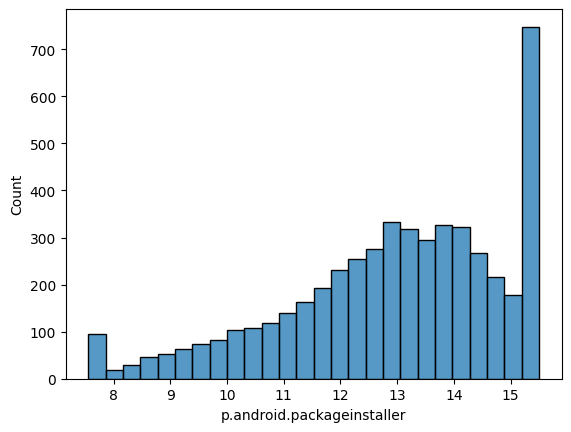

In [57]:
sns.histplot(p_android_packageinstaller_0)

In [58]:
p_android_packageinstaller_1 = df_processes.loc[df_processes.mwra == 1, 'p.android.packageinstaller']
p_android_packageinstaller_1.describe()

count    7217.000000
mean       10.210949
std         1.755301
min         7.551433
25%         8.910720
50%        10.103580
75%        11.331640
max        15.502532
Name: p.android.packageinstaller, dtype: float64

<Axes: xlabel='p.android.packageinstaller', ylabel='Count'>

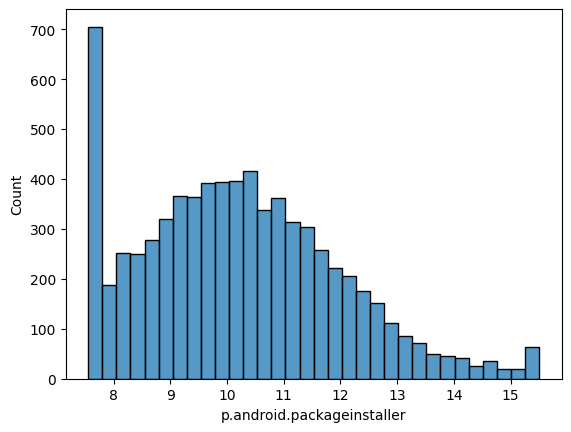

In [59]:
sns.histplot(p_android_packageinstaller_1)

Z týchto distribúcií môžeme vidieť, že nevyzerajú ako normálne distribúcie, preto musíme pokračovať s overením.

In [60]:
p_android_packageinstaller_0_outliers = identify_outliers(p_android_packageinstaller_0)
p_android_packageinstaller_1_outliers = identify_outliers(p_android_packageinstaller_1)

In [61]:
p_android_packageinstaller_0_outliers.count()

np.int64(96)

In [62]:
p_android_packageinstaller_1_outliers.count()

np.int64(87)

In [63]:
p_android_packageinstaller_0 = p_android_packageinstaller_0.drop(p_android_packageinstaller_0_outliers.index)
p_android_packageinstaller_1 = p_android_packageinstaller_1.drop(p_android_packageinstaller_1_outliers.index)

<Axes: xlabel='p.android.packageinstaller', ylabel='Count'>

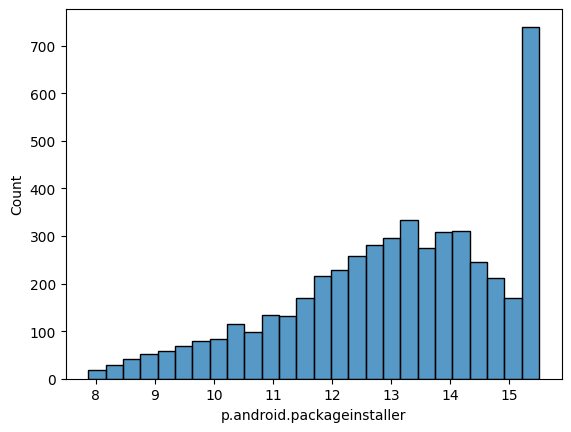

In [64]:
sns.histplot(p_android_packageinstaller_0)

<Axes: xlabel='p.android.packageinstaller', ylabel='Count'>

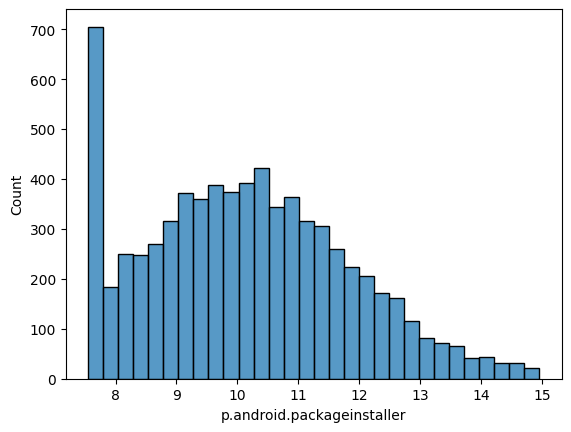

In [65]:
sns.histplot(p_android_packageinstaller_1)

Vidíme že aj po vyhodení outlierov sa nám distribúcia nezmenila a preto môžeme pokračovať s testovaním.

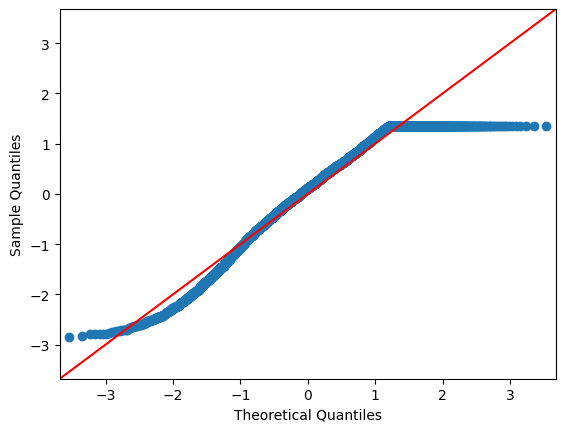

In [66]:
_ = sm.ProbPlot(p_android_packageinstaller_0, fit=True).qqplot(line='45')

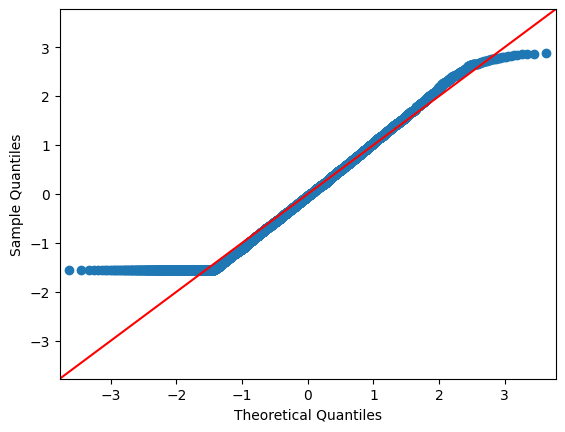

In [67]:
_ = sm.ProbPlot(p_android_packageinstaller_1, fit=True).qqplot(line='45')

Ani `QQ-plot` nám nepotvrdil normálnu distribúciu. Pretože aby bola distribúcia normálna, tak by sa body museli nachádzať na priamke definovanej ako $x=y$.

In [68]:
p_android_packageinstaller_0.count()

np.int64(4951)

In [69]:
p_android_packageinstaller_1.count()

np.int64(7130)

Musíme použiť štatistický test, ktorý nám povie či dáta majú normálnu distribúciu alebo nie. Použijeme `Shapiro-Wilk` test pre jednu premennú a `Kolmogorov-Smirnov` pre druhú premennú pretože pri jednej je počet záznamov je nižší ako 5000 a pri druhej vyšší.

In [70]:
# Shapiro-Wilk test
print_normality_test(p_android_packageinstaller_0)

stat: for count=4951: [stat: 0.9518286197121643, p: 1.4554527370790357e-37, norm: False]


In [71]:
# Kolmogorov-Smirnov test
print_normality_test(p_android_packageinstaller_1)

kstest for count=7130: [stat: 0.9999999999999785, p: 0.0, norm: False]


Výsledok testu nám potvrdil, že dáta nemajú normálnu distribúciu, preto musíme použiť neparametrický test na overenie hypotézy. Pretože p hodnota je menšia ako 0.05.

Použijeme `Mann-Whitney U Test` pretože máme práve dve premenné a zároveň spĺňajú predpoklady pre tento test (vzorka musí byť aspoň 20).

In [72]:
stats.mannwhitneyu(p_android_packageinstaller_0, p_android_packageinstaller_1)

MannwhitneyuResult(statistic=np.float64(30729600.0), pvalue=np.float64(0.0))

Keďže nám vyšlo p menšie ako 0.05 tak zamietame nulovú hypotézu a prijímame alternatívnu hypotézu, že premenná `p.android.packageinstaller` má v priemere inú váhu v stave malware-related-activity ako v normálnom stave.

#### 1.3.B Overenie štatistickej sily

Kedže nám p values vyšli všetky menšie ako 0.001, tak môžeme povedať že naše testy mali veľkú štatistickú silu.

## Fáza 2 - Predspracovanie údajov

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [74]:
df_connections = pd.read_csv('112/connections.csv', delimiter=',')
df_processes   = pd.read_csv('112/processes.csv', delimiter=',')

### 2.1 Realizácia predspracovania dát

#### 2.1.A Dáta si rozdeľte na trénovaciu a testovaciu množinu podľa vami preddefinovaného pomeru. Ďalej pracujte len s trénovacím datasetom.

In [75]:
merged_data = df_connections.merge(df_processes, on=['imei', 'ts'], how='inner')

In [76]:
merged_data['ts'] = pd.to_numeric(pd.to_datetime(merged_data['ts'], errors='coerce'))

Po načítaní datasetov z `.csv` súborov sme si ich spojili na základe spoločného stĺpca `imei` a `ts` a upravili sme dátový typ stĺpca `ts` aby sa nám s ním neskôr dalo pracovať.

Na základe výsledkov a zistení vo fázy 1, sme použili iba datasety `processes.csv` a `connections.csv` pretože obsahujú numerické hodnoty, ktoré sú vhodné pre modelovanie.

In [77]:
merged_data.describe()

,ts,imei,mwra_x,c.android.youtube,c.katana,c.dogalize,c.android.chrome,c.android.gm,c.raider,c.UCMobile.x86,c.android.vending,c.updateassist,c.UCMobile.intl,mwra_y,p.system,p.android.chrome,...,p.android.packageinstaller,p.android.externalstorage,p.android.documentsui,p.simulator,p.browser.provider,p.gms.persistent,p.android.gms,p.android.defcontainer,p.google,p.dogalize,p.notifier,p.inputmethod.latin,p.android.vending,p.katana,p.process.gapps,p.olauncher
count,1.548400e+04,1.548400e+04,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,...,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000,15484.000000
mean,1.525963e+18,3.899250e+18,0.625549,11.645562,12.836578,11.099840,10.457320,12.287215,52.271752,50.013360,49.434043,50.057145,50.223821,0.625549,11.015700,10.982338,...,11.102894,11.624995,12.272227,50.368378,1.109710,44.687156,51.237915,50.089239,49.635597,49.689558,50.265800,49.816437,49.722095,49.729257,49.504947,49.776723
std,2.589882e+14,3.315960e+18,0.483996,2.515302,2.518533,2.632783,2.465467,2.649583,13.070488,13.096605,28.963127,28.905650,28.779510,0.483996,2.379183,2.644171,...,2.502951,2.724005,2.560431,13.020500,2.820649,12.390675,12.330157,28.870871,29.007596,28.912953,28.741962,29.029859,28.700844,28.994626,29.080200,28.860743
min,1.525514e+18,3.590434e+17,0.000000,2.971740,1.421750,1.903820,0.000000,0.909510,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187180,3.433080,...,3.607510,1.942770,2.911910,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.525739e+18,8.630331e+17,0.000000,9.749760,11.197252,9.209870,8.774425,10.485835,43.486850,41.073745,24.443035,25.056397,25.345723,0.000000,9.251787,9.147198,...,9.277985,9.648440,10.436625,41.455755,0.026722,36.413538,42.902673,24.936100,24.586685,24.361068,25.786430,24.635683,25.363378,24.397513,24.022455,24.710783
50%,1.525963e+18,3.590434e+18,1.000000,11.549260,12.943445,10.938180,10.329705,12.493865,52.240670,50.044030,49.195500,50.227600,49.962240,1.000000,10.985515,10.589795,...,10.865450,11.733685,12.390830,50.472055,0.138690,44.682500,51.135040,50.654625,49.184500,49.652090,50.339050,49.794825,49.735255,49.380970,49.844280,49.478445
75%,1.526188e+18,8.630331e+18,1.000000,13.510697,14.587673,12.941770,12.071272,14.163263,61.053025,58.821040,74.641220,74.969005,75.214025,1.000000,12.958982,12.490782,...,12.839568,13.637355,14.129073,59.143693,0.979490,52.931440,59.609805,75.108980,74.873525,74.892947,75.195472,75.380165,74.124343,74.936873,74.714517,74.826770
max,1.526411e+18,8.630331e+18,1.000000,20.535130,22.040750,21.856290,19.637920,20.838850,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000,17.587580,23.894880,...,21.589900,20.581850,21.911690,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [78]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15484 entries, 0 to 15483
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ts                          15484 non-null  int64  
 1   imei                        15484 non-null  int64  
 2   mwra_x                      15484 non-null  float64
 3   c.android.youtube           15484 non-null  float64
 4   c.katana                    15484 non-null  float64
 5   c.dogalize                  15484 non-null  float64
 6   c.android.chrome            15484 non-null  float64
 7   c.android.gm                15484 non-null  float64
 8   c.raider                    15484 non-null  float64
 9   c.UCMobile.x86              15484 non-null  float64
 10  c.android.vending           15484 non-null  float64
 11  c.updateassist              15484 non-null  float64
 12  c.UCMobile.intl             15484 non-null  float64
 13  mwra_y                      154

In [79]:
merged_data.loc[merged_data['mwra_x'] != merged_data['mwra_y']]['imei'].count() / merged_data['imei'].count()

np.float64(0.0)

In [80]:
merged_data = merged_data.drop_duplicates()

In [81]:
merged_data = merged_data.drop(columns=['mwra_y'])

In [82]:
merged_data = merged_data.rename(columns={"mwra_x": "mwra"})

In [83]:
X = merged_data.drop(columns='mwra')
y = merged_data['mwra']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Objavili sa nám 2 stĺpce `mwra`, tak smeoverili, či sú medyi nimi nejaké rozdiely, konkrétne `mwra_x` a `mwra_y` a zistili sme že sú rovnaké (bol to dôsledok joinu, pretože `mwra` sa nachádzala v oboch súboroch), preto sme jeden z nich odstránili.
Následne sme si rozdelili naše dáta na trénovaciu a testovaciu časť podľa pomeru 80:20 (trénovacia : testovacia).

#### 2.1.B Transformujte dáta na vhodný formát pre ML t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte (encoding). zIteratívne integrujte aj kroky v predspracovaní dát z prvej fázy (missing values, outlier detection) ako celok. 

##### Missing values (Chýbajúce hodnoty)

In [85]:
X_train.isnull().sum().sum()

np.int64(0)

In [86]:
imputer = SimpleImputer(strategy='mean')
X_train_impute = imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train_impute, columns=X_train.columns, index=X_train.index)

Zistili sme, že nemáme žiadne missing values v našich dátach, avšak ako prípravu na pipeline sme si urobili `imputer`, ktorý by prípadné chýbajúce hodnoty nahradil za priemer (keďže nepracujeme s testovacím datasetom ale iba trénovacím).

Keďže všetky naše hodnoty majú numerický formát, tak nemusíme robiť encoding.

##### Handling outliers (Ošetrovanie outlierov)

In [87]:
def handle_outliers(X, y):
    X_temp = X.copy()
    indices_remove = set()
    for column in X.columns:
        outliers = identify_outliers(X[column])
        if outliers.count() / X[column].count() < 0.05:
            indices_remove.update(outliers.index)
        
    X_temp = X.drop(index=indices_remove)
    y = y.drop(index=indices_remove)

    X_temp = replace_outliers_with_percentiles(X_temp)
    
    return X_temp, y

In [88]:
X_train.count().max()

np.int64(11957)

<Axes: xlabel='p.browser.provider', ylabel='Count'>

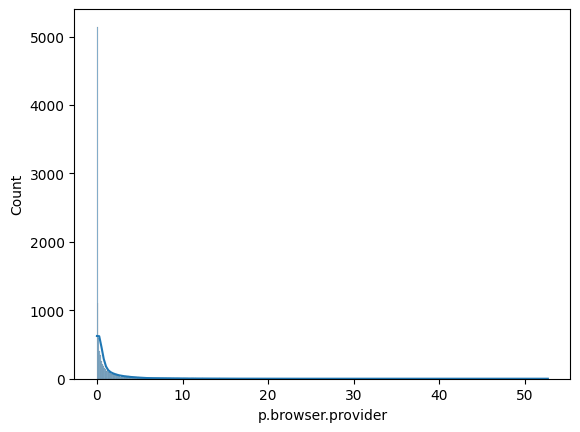

In [89]:
sns.histplot(X_train['p.browser.provider'], kde=True)

In [90]:
identify_outliers_for_all_columns(X_train)

{'c.android.youtube': np.int64(15),
 'c.katana': np.int64(76),
 'c.dogalize': np.int64(32),
 'c.android.chrome': np.int64(75),
 'c.android.gm': np.int64(35),
 'c.raider': np.int64(80),
 'c.UCMobile.x86': np.int64(64),
 'p.system': np.int64(7),
 'p.android.chrome': np.int64(193),
 'p.android.settings': np.int64(122),
 'p.android.gm': np.int64(51),
 'p.android.packageinstaller': np.int64(44),
 'p.android.externalstorage': np.int64(16),
 'p.android.documentsui': np.int64(26),
 'p.simulator': np.int64(85),
 'p.browser.provider': np.int64(1510),
 'p.gms.persistent': np.int64(97),
 'p.android.gms': np.int64(78)}

In [91]:
X_train, y_train = handle_outliers(X_train, y_train)

In [92]:
X_train.count().max()

np.int64(10931)

In [93]:
identify_outliers_for_all_columns(X_train)

{'p.browser.provider': np.int64(1346)}

<Axes: xlabel='p.browser.provider', ylabel='Count'>

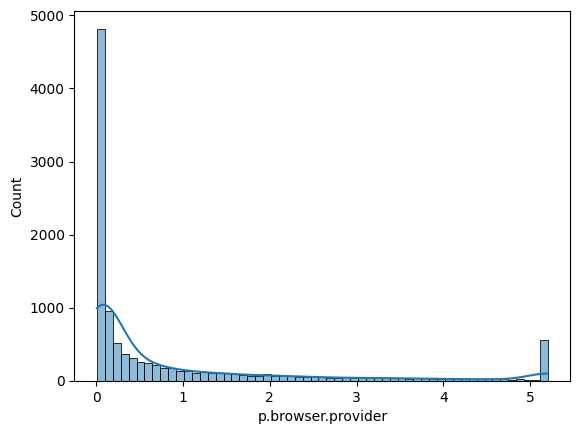

In [94]:
sns.histplot(X_train['p.browser.provider'], kde=True)

Outlierov sme vyriešili podobne ako v prvej fáze. Ak bol počet outlierov v jednom stĺpci vacčší ako 5% z celkového počtu záznamov, tak sme ich nahradili hraničnými hodnotami (5 a 95 percentil), ak boli menšie, tak sme ich odstránili. Na ukážku sme zobrazili graf premennej `p.browser.provider` a zistili sme že aj po odstránení outlierov, máme zase ďalších, ale ďaľej sme nepokračovali v ich odstraňovaní, pretože by sme prišli o veľký počet záznamov.

#### 2.1.C Transformujte atribúty dát pre strojové učenie podľa dostupných techník minimálne: scaling (2 techniky), transformers (2 techniky) a ďalšie. Cieľom je aby ste testovali efekty a vhodne kombinovali v dátovom pipeline (od časti 2.3 a v 3. fáze).

##### Ukážka distribúcií našich dát pred škálovaním a transformáciou

In [95]:
moderate_predictors

,mwra
c.dogalize,-0.538271
p.android.gm,0.567423
p.android.packageinstaller,-0.579099


In [96]:
weak_predictors

,mwra
c.katana,0.285185
c.android.gm,-0.271405
c.android.chrome,-0.294828
p.system,0.310021
p.android.chrome,0.260711
p.android.documentsui,-0.285944


In [97]:
def plot_predictor_distribution(in_df, series_mwra, predictors):
    df = in_df.copy()
    df['mwra'] = series_mwra
    num_predictors = len(predictors)
    fig, axes = plt.subplots(1, num_predictors, figsize=(5 * num_predictors, 5), sharey=True)  # sharey=True to share the y-axis scale
    for i, predictor in enumerate(predictors.index):
       sns.kdeplot(data=df, x=predictor, hue="mwra", fill=True, common_norm=False, alpha=0.5, ax=axes[i])
    fig.tight_layout()
    plt.show()

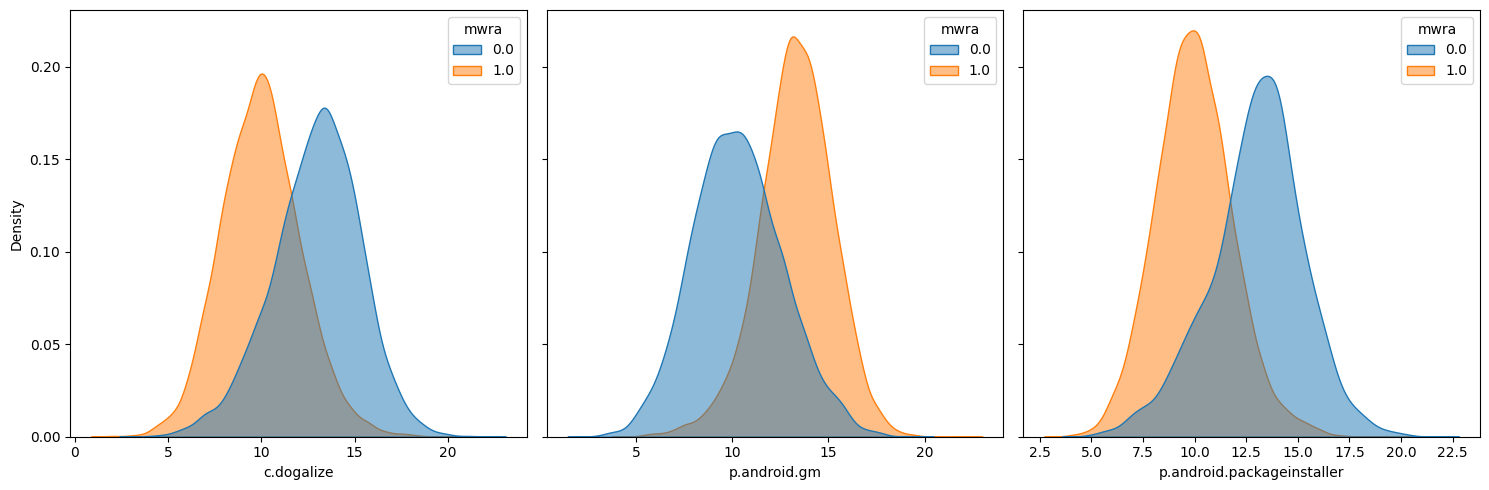

In [98]:
plot_predictor_distribution(merged_data, merged_data['mwra'], moderate_predictors)

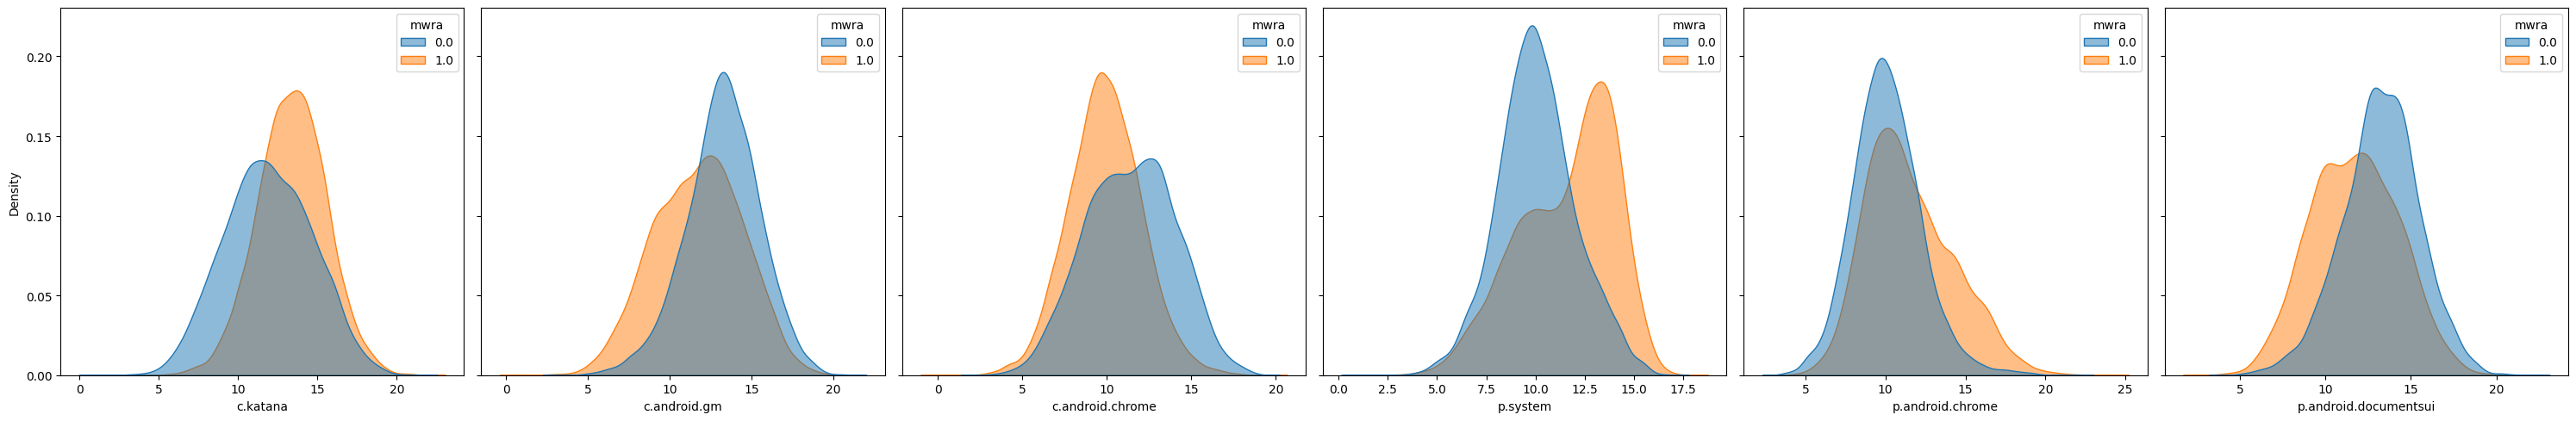

In [99]:
plot_predictor_distribution(merged_data, merged_data['mwra'], weak_predictors)

##### Škálovanie (Scaling)

Vyskúšame viacej metód škálovania, a neskôr zistíme ktorá je pre nás najvhodnejšia v spojení s transformáciou.

In [100]:
min_max_scaler = MinMaxScaler()
X_train_normalized = min_max_scaler.fit_transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns, index=X_train.index)

standard_scaler = StandardScaler()
X_train_standardized = standard_scaler.fit_transform(X_train)
X_train_standardized = pd.DataFrame(X_train_standardized, columns=X_train.columns, index=X_train.index)

robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(X_train)
X_train_robust = pd.DataFrame(X_train_robust, columns=X_train.columns, index=X_train.index)

Na ukážku používame naše predikátory z fázy 1, pretože predpokladáme že to budú najdôležitejšie premenné resp. črty (features).

**Normalizácia dát (MinMaxScaler)**

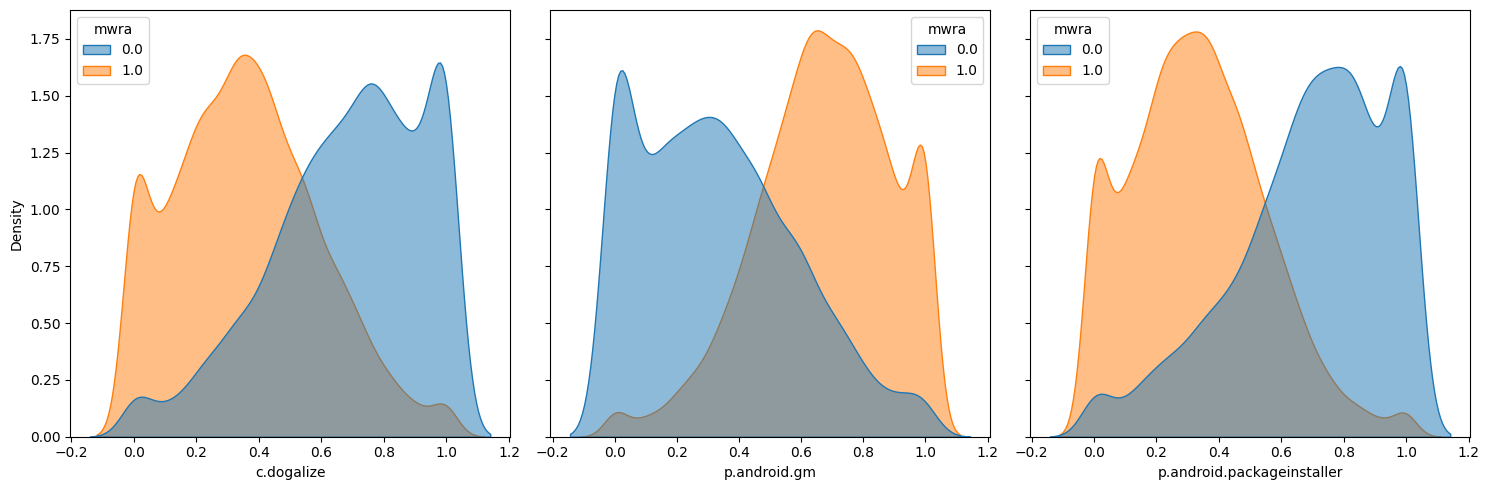

In [101]:
plot_predictor_distribution(X_train_normalized, y_train, moderate_predictors)

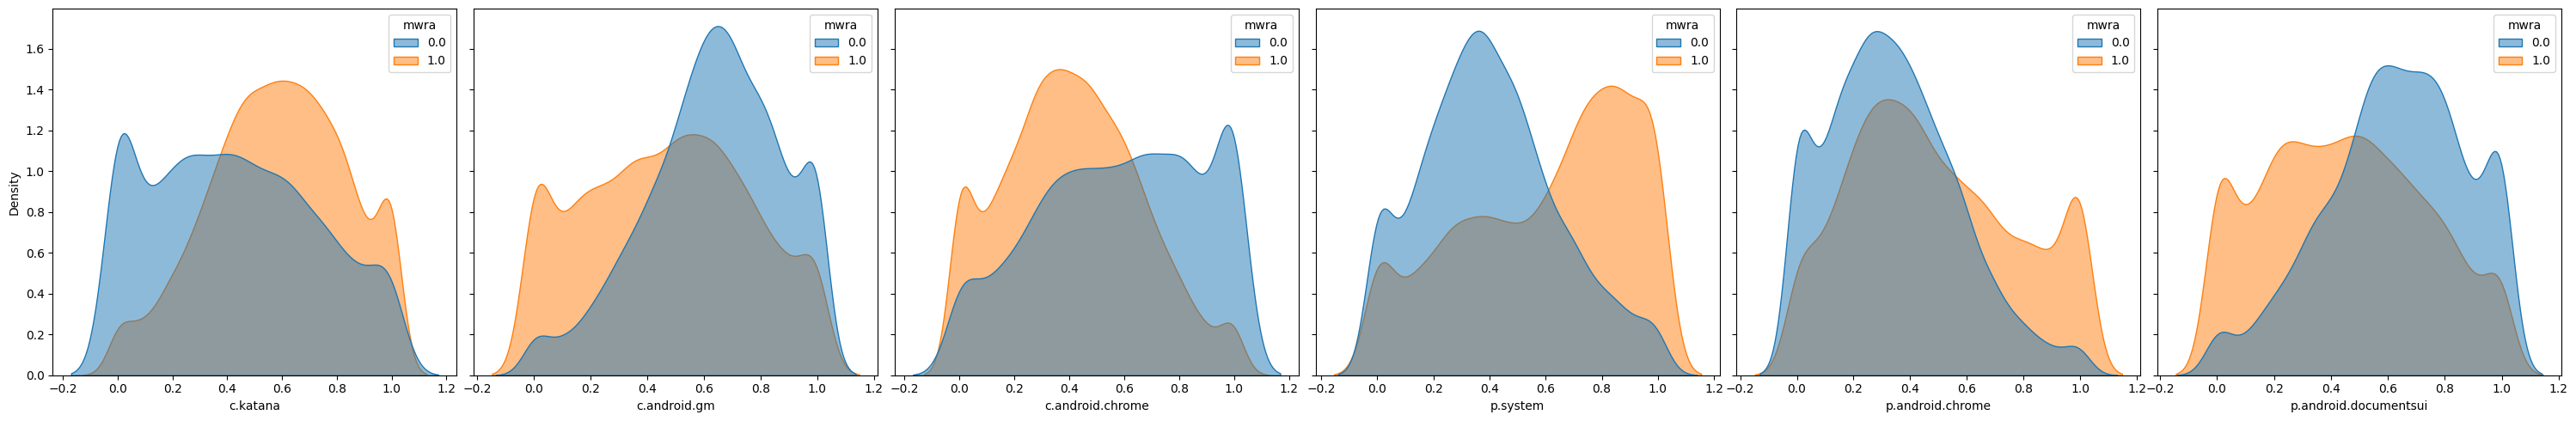

In [102]:
plot_predictor_distribution(X_train_normalized, y_train, weak_predictors)

**Štandardizácia dát (StandardScaler)**

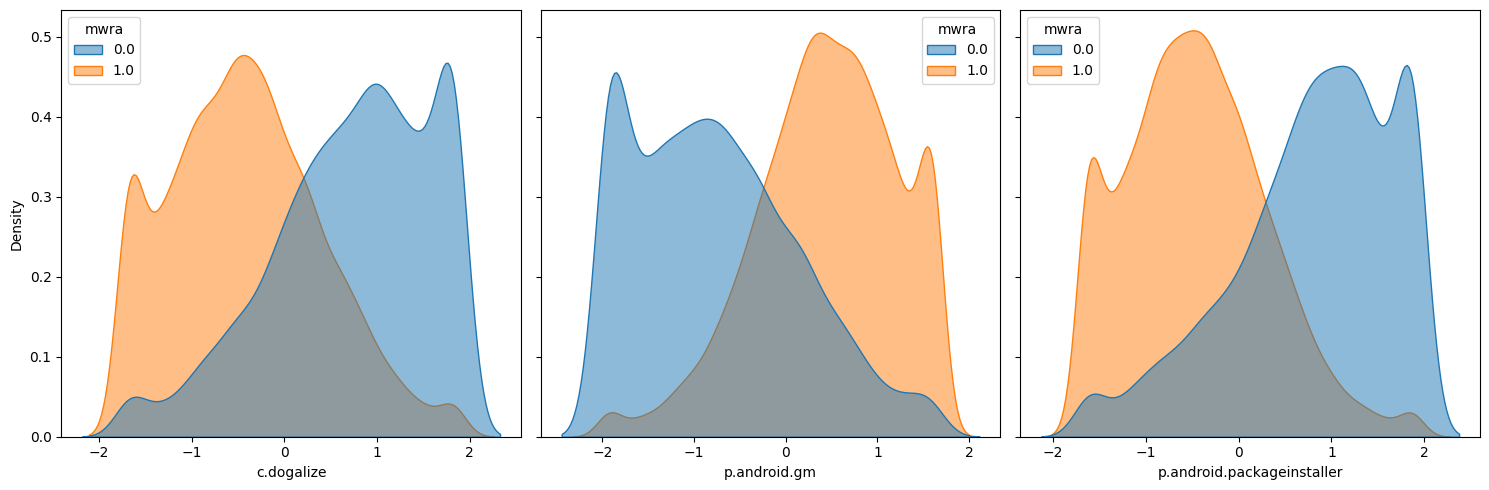

In [103]:
plot_predictor_distribution(X_train_standardized, y_train, moderate_predictors)

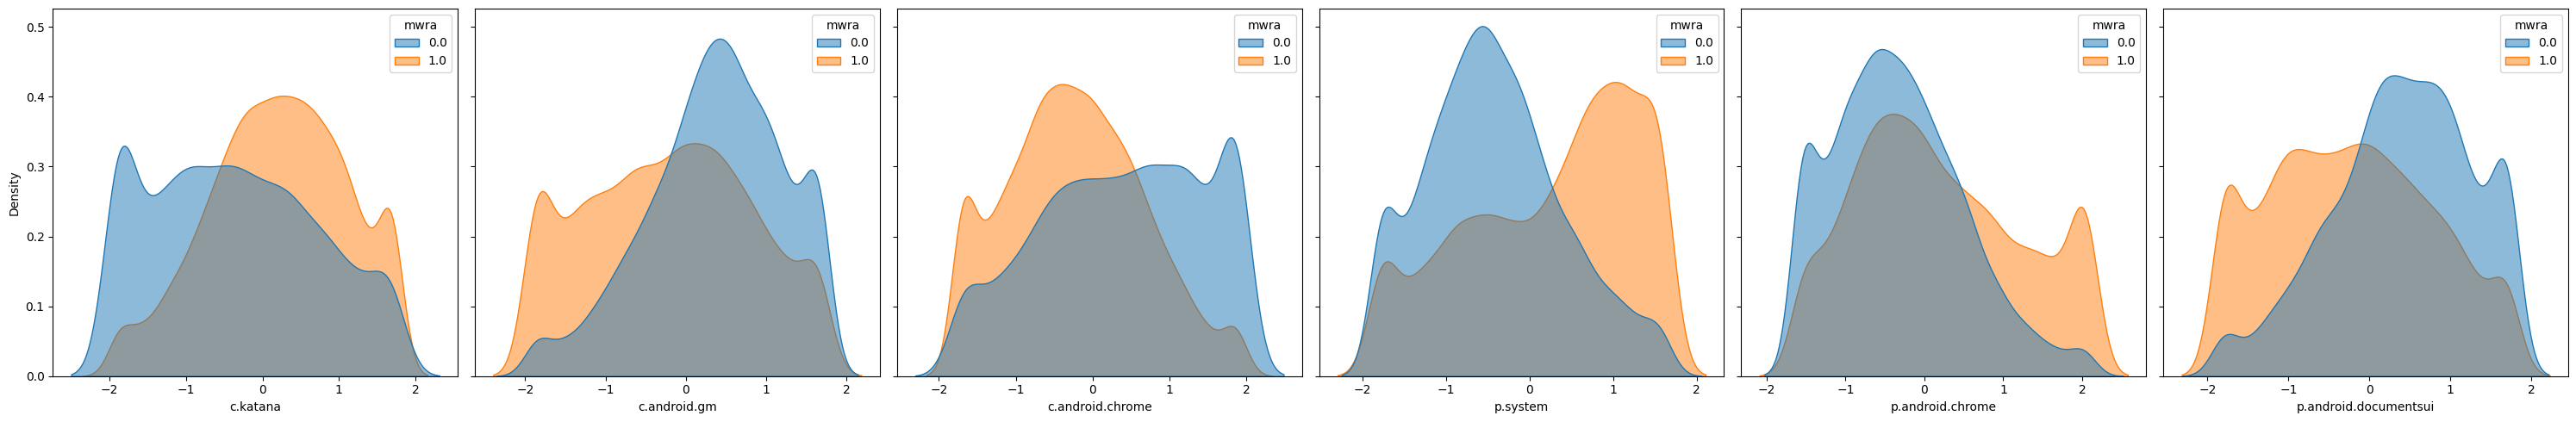

In [104]:
plot_predictor_distribution(X_train_standardized, y_train, weak_predictors)

**Robustné škálovanie (RobustScaler)**

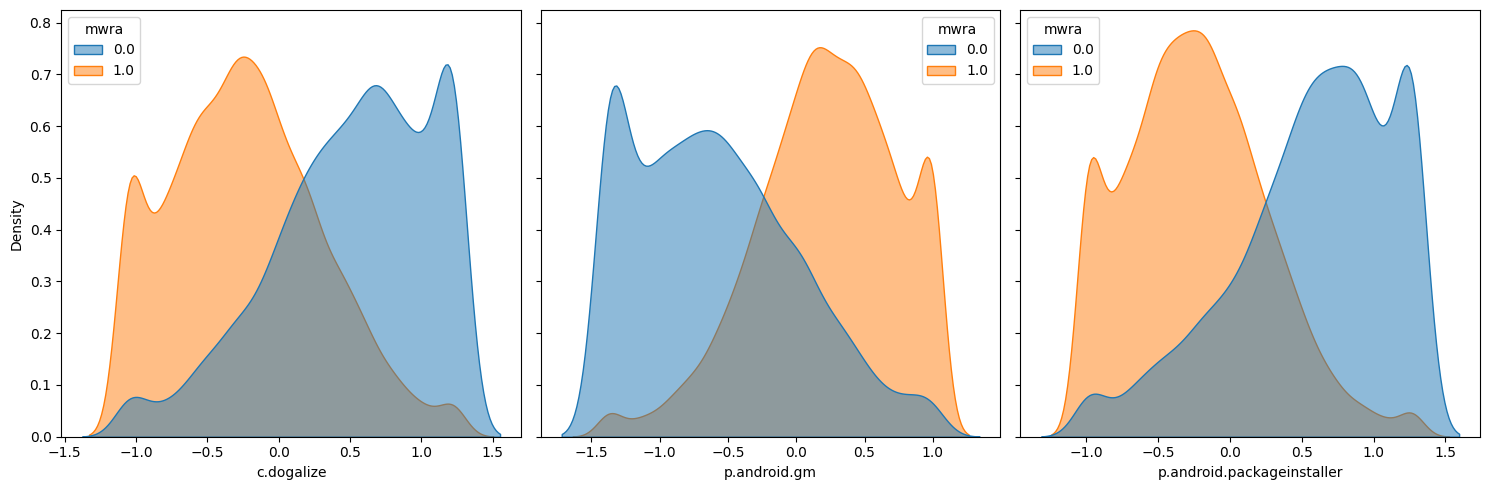

In [105]:
plot_predictor_distribution(X_train_robust, y_train, moderate_predictors)

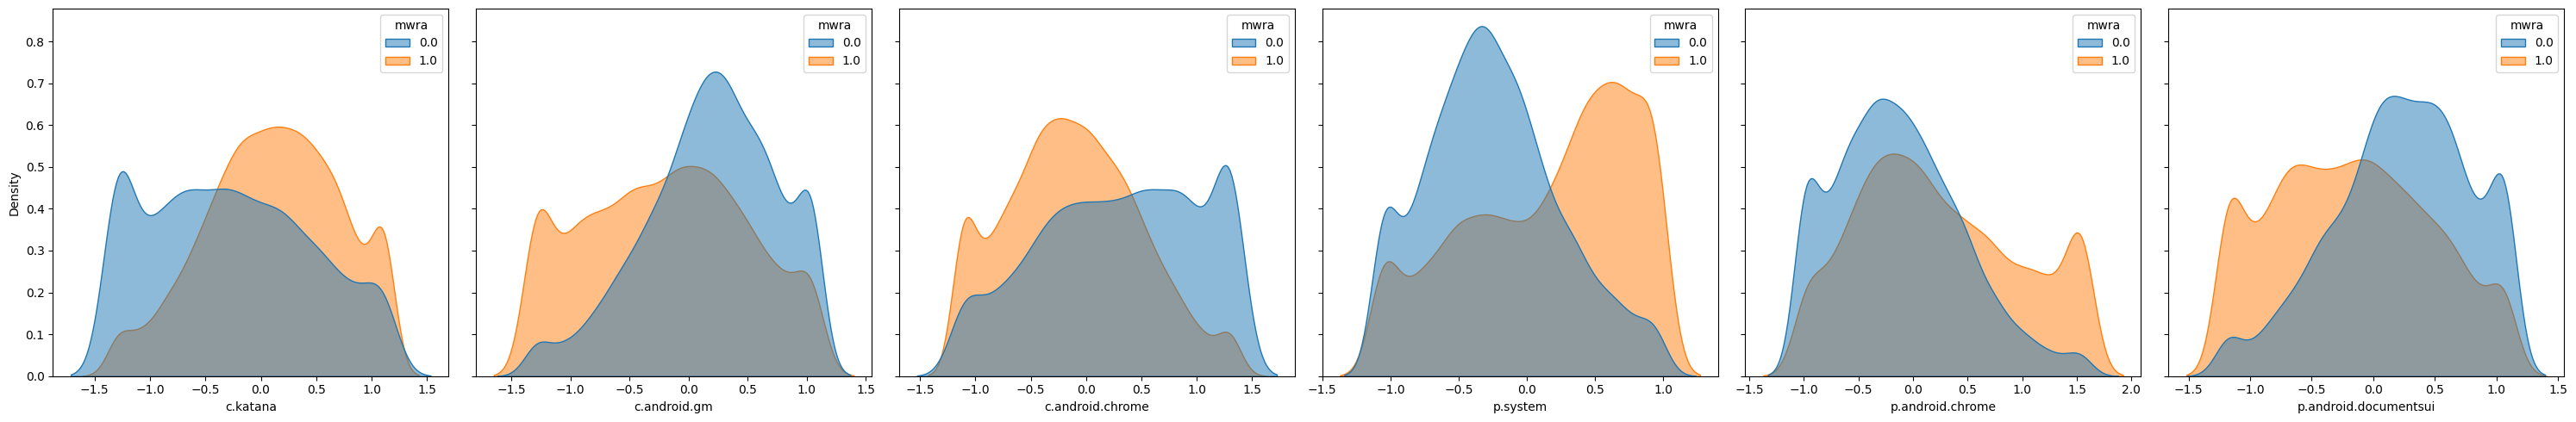

In [106]:
plot_predictor_distribution(X_train_robust, y_train, weak_predictors)

Grafy nám všake ukazujú distribúcie, ktoré by mohli byť podobné normálnej distribúcii (s nejakými výnimkami), avšak sú "skewed" a ich konce (tails) sú viacej špičaté, čo bolo spôsobné nahradením outlierov hraničnými hodnotami.

##### Transformations

Vyskúšame taktiež viacej metód transformovania pre každé škálovanie, a neskôr zistíme ktorá je pre nás najvhodnejšia.

In [107]:
power_transformer = PowerTransformer(method='yeo-johnson')
quantile_transformer = QuantileTransformer(n_quantiles=1000, random_state=0)

In [108]:
X_train_normalized_power = power_transformer.fit_transform(X_train_normalized)
X_train_normalized_quantile = quantile_transformer.fit_transform(X_train_normalized)

X_train_standardized_power = power_transformer.fit_transform(X_train_standardized)
X_train_standardized_quantile = quantile_transformer.fit_transform(X_train_standardized)

X_train_robust_power = power_transformer.fit_transform(X_train_robust)
X_train_robust_quantile = quantile_transformer.fit_transform(X_train_robust)

In [109]:
X_train_normalized_power = pd.DataFrame(X_train_normalized_power, columns=X_train_normalized.columns, index=X_train_normalized.index)
X_train_normalized_quantile = pd.DataFrame(X_train_normalized_quantile, columns=X_train_normalized.columns, index=X_train_normalized.index)
X_train_standardized_power = pd.DataFrame(X_train_standardized_power, columns=X_train_standardized.columns, index=X_train_standardized.index)
X_train_standardized_quantile = pd.DataFrame(X_train_standardized_quantile, columns=X_train_standardized.columns, index=X_train_standardized.index)
X_train_robust_power = pd.DataFrame(X_train_robust_power, columns=X_train_robust.columns, index=X_train_robust.index)
X_train_robust_quantile = pd.DataFrame(X_train_robust_quantile, columns=X_train_robust.columns, index=X_train_robust.index)

<font color='#38C570'>
    <b>
        Transformácia dát (PowerTransformer), s normalizáciou dát (MinMaxScaler)
    </b>
</font>

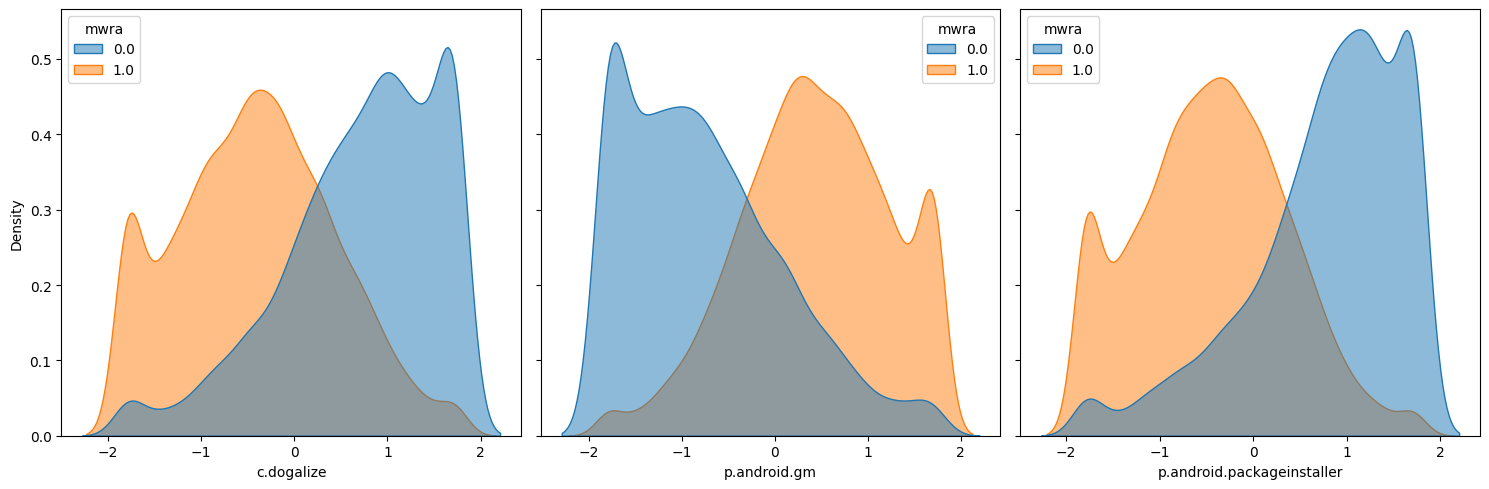

In [110]:
plot_predictor_distribution(X_train_normalized_power, y_train, moderate_predictors)

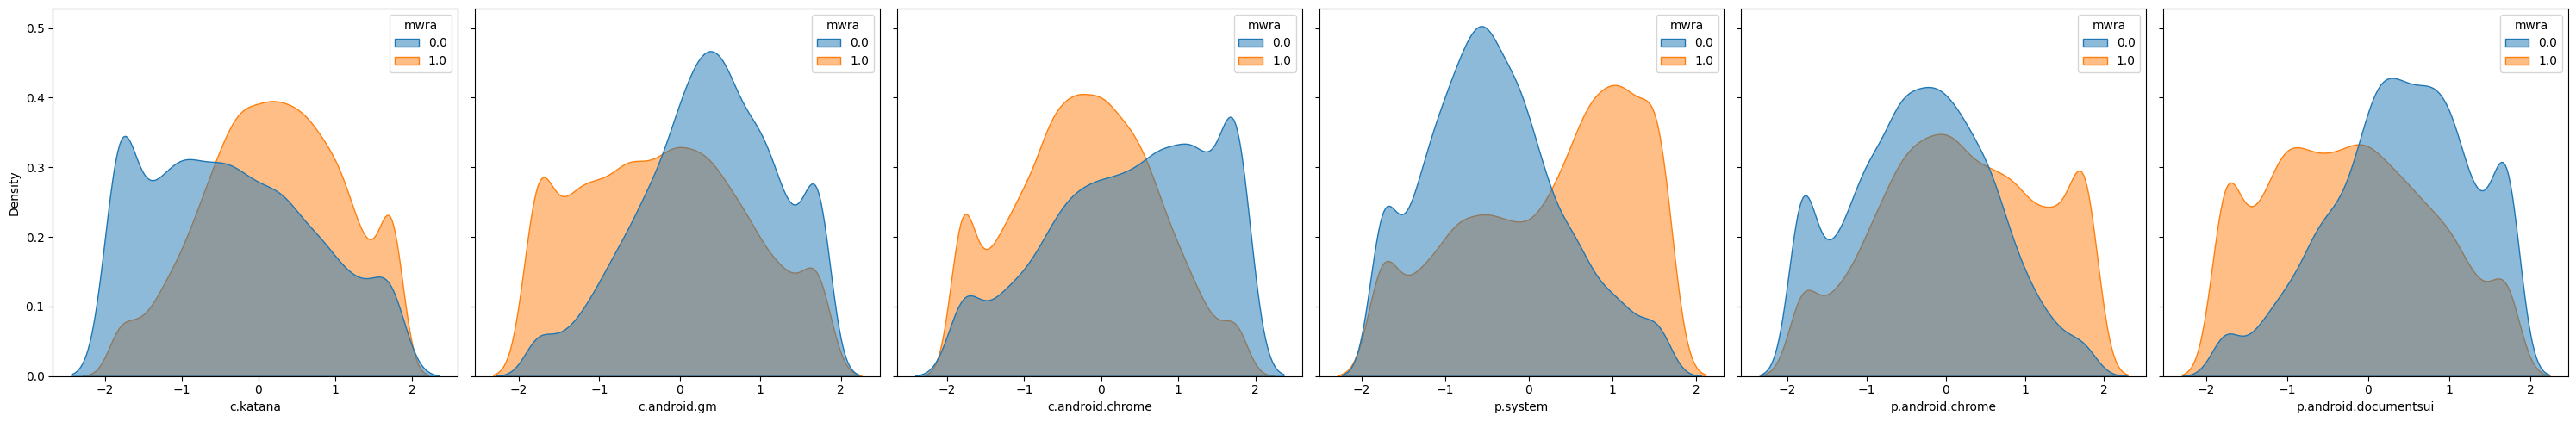

In [111]:
plot_predictor_distribution(X_train_normalized_power, y_train, weak_predictors)

**Transformácia dát (QuantileTransformer), s normalizáciou dát (MinMaxScaler)**

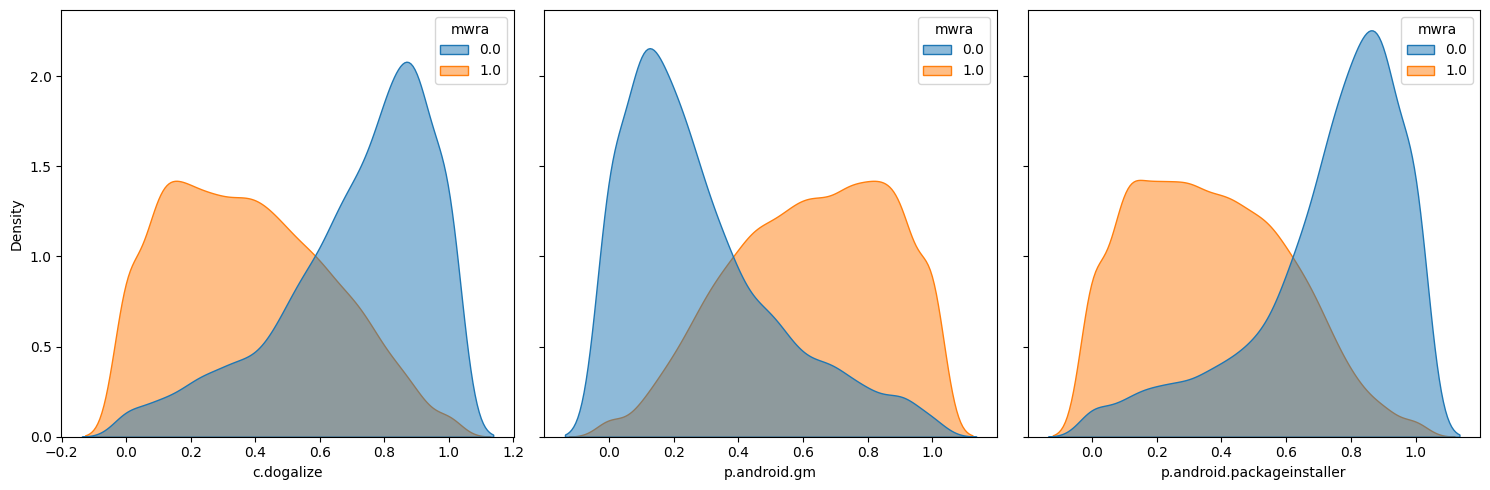

In [112]:
plot_predictor_distribution(X_train_normalized_quantile, y_train, moderate_predictors)

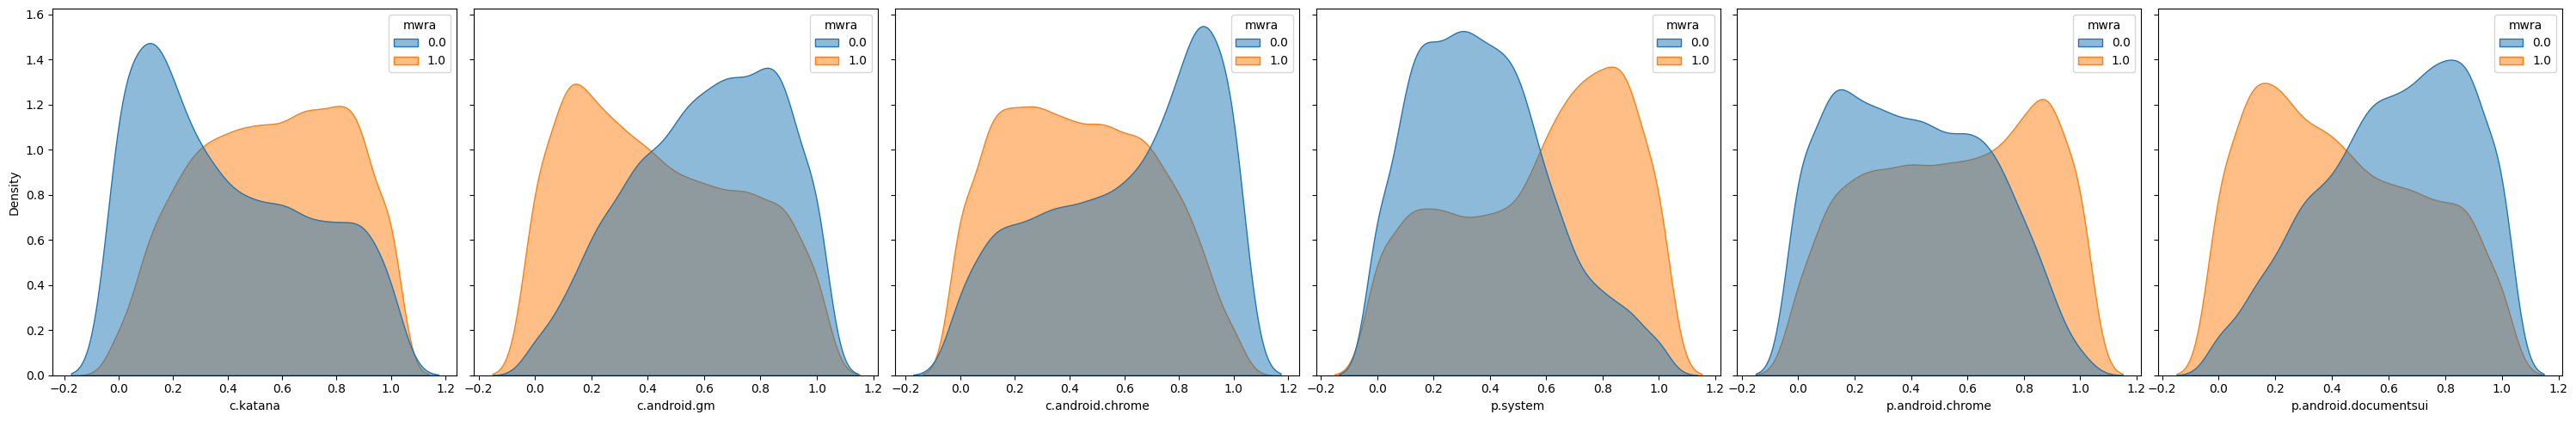

In [113]:
plot_predictor_distribution(X_train_normalized_quantile, y_train, weak_predictors)

**Transformácia dát (PowerTransformer), s štandardizáciou dát (StandardScaler)**

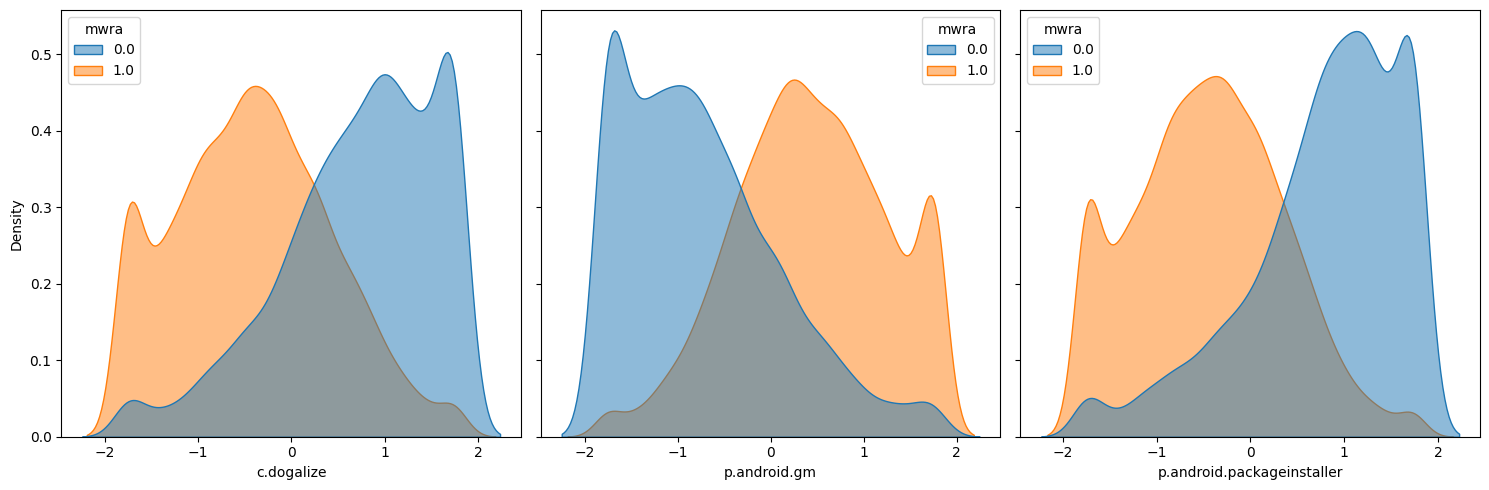

In [114]:
plot_predictor_distribution(X_train_standardized_power, y_train, moderate_predictors)

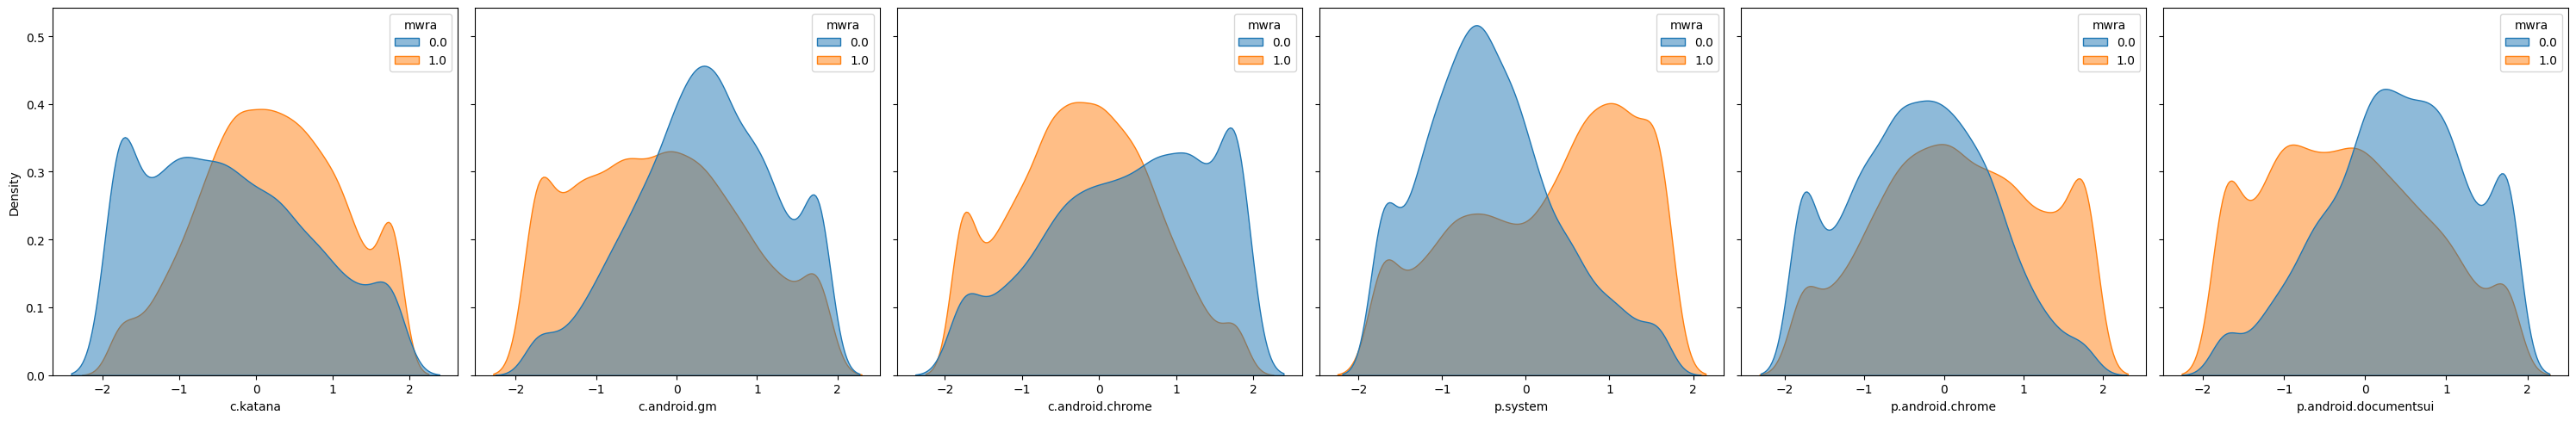

In [115]:
plot_predictor_distribution(X_train_standardized_power, y_train, weak_predictors)

**Transformácia dát (QuantileTransformer), s štandardizáciou dát (StandardScaler)**

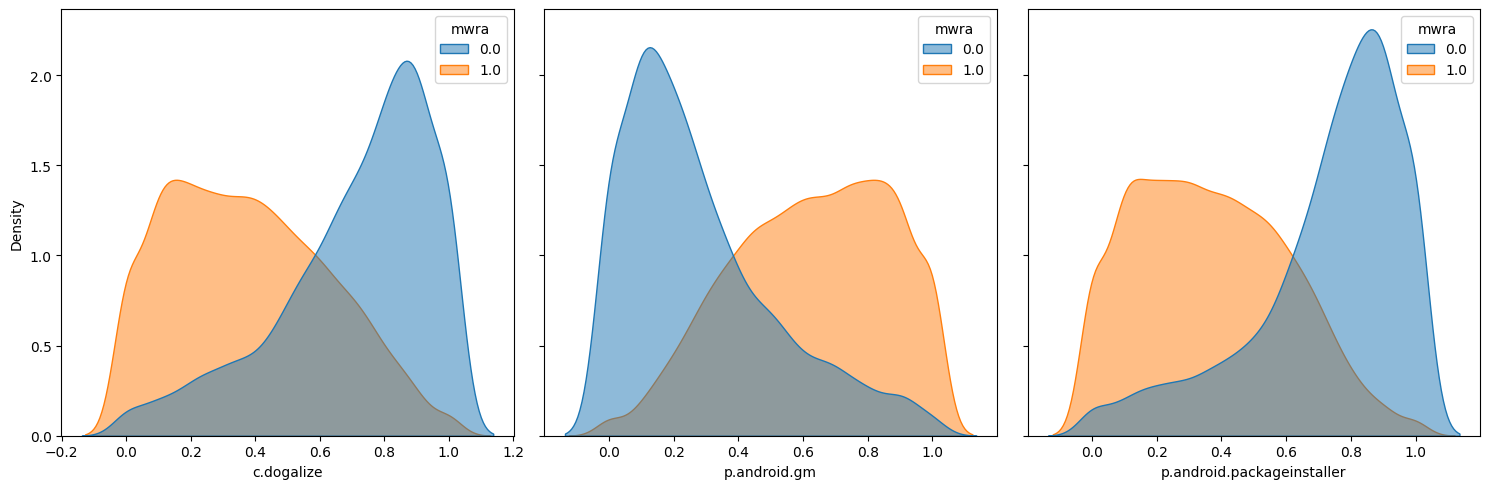

In [116]:
plot_predictor_distribution(X_train_standardized_quantile, y_train, moderate_predictors)

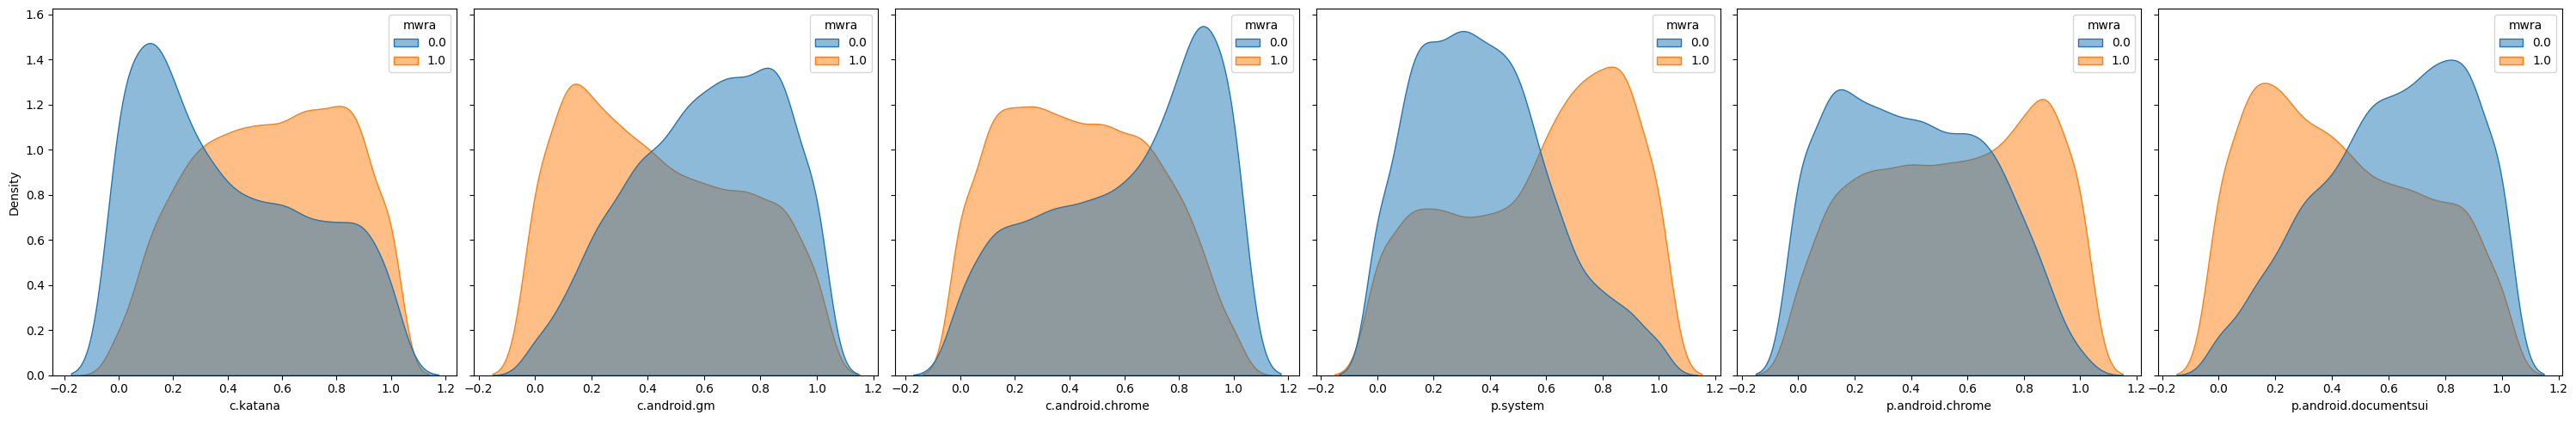

In [117]:
plot_predictor_distribution(X_train_standardized_quantile, y_train, weak_predictors)

**Transformácia dát (PowerTransformer), s robustným škálovaním (RobustScaler)**

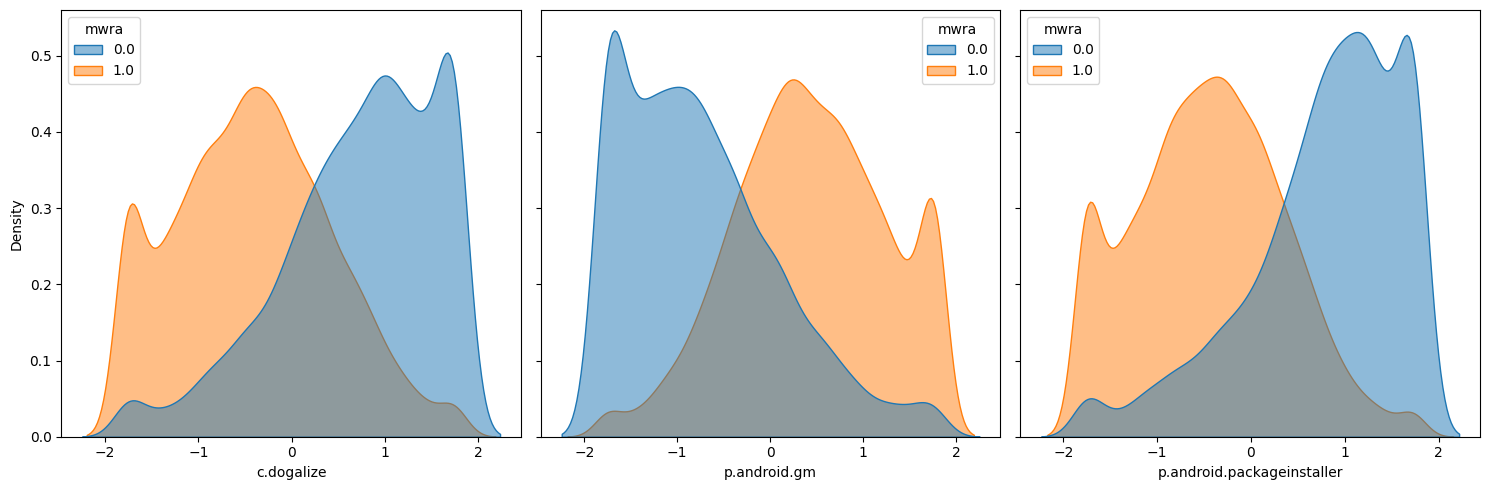

In [118]:
plot_predictor_distribution(X_train_robust_power, y_train, moderate_predictors)

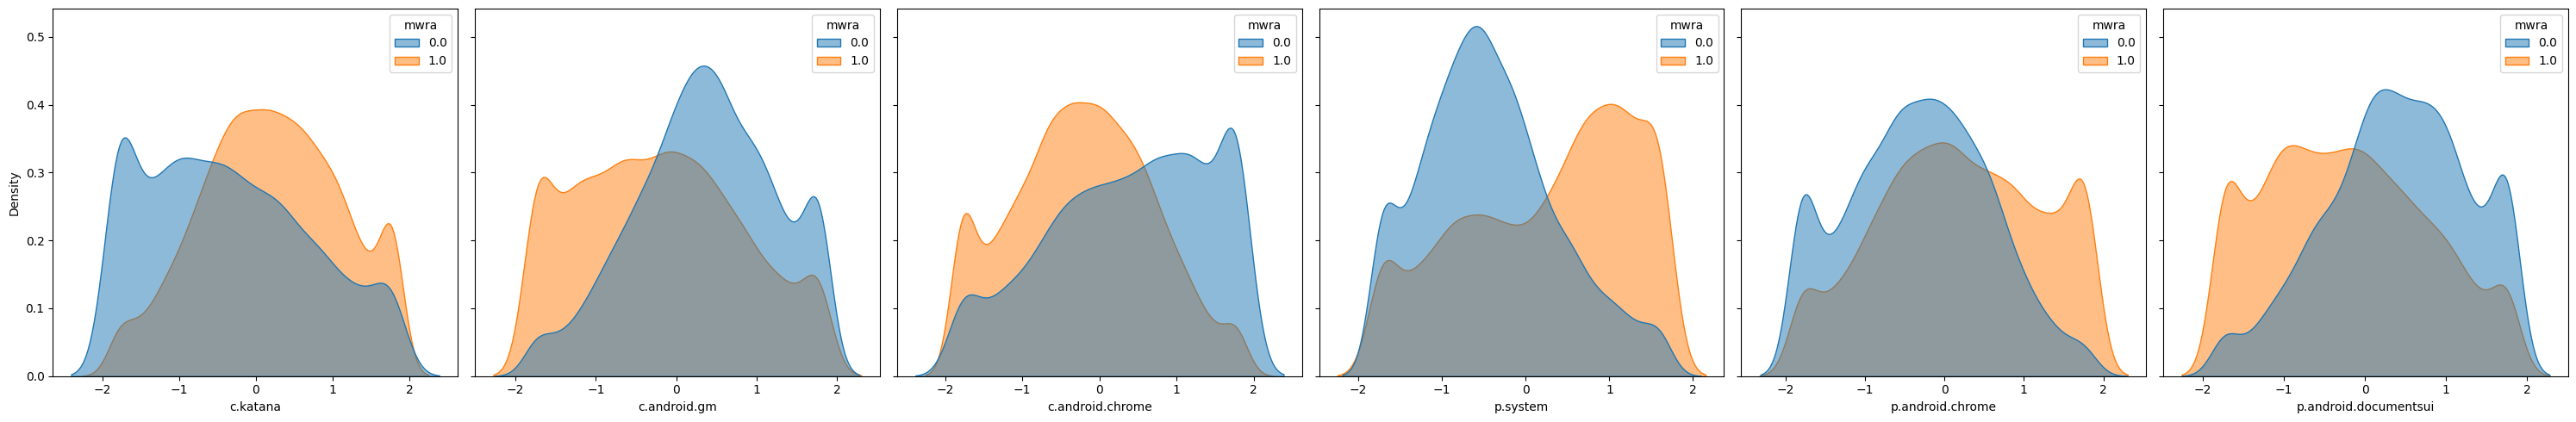

In [119]:
plot_predictor_distribution(X_train_robust_power, y_train, weak_predictors)

**Transformácia dát (QuantileTransformer), s robustným škálovaním (RobustScaler)**

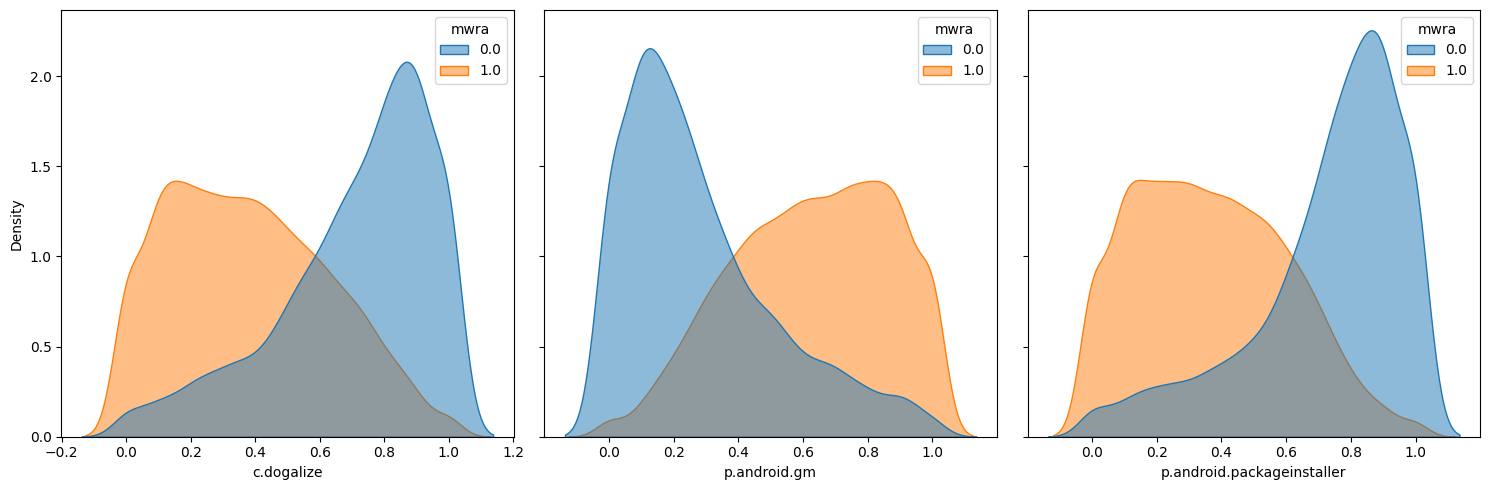

In [120]:
plot_predictor_distribution(X_train_robust_quantile, y_train, moderate_predictors)

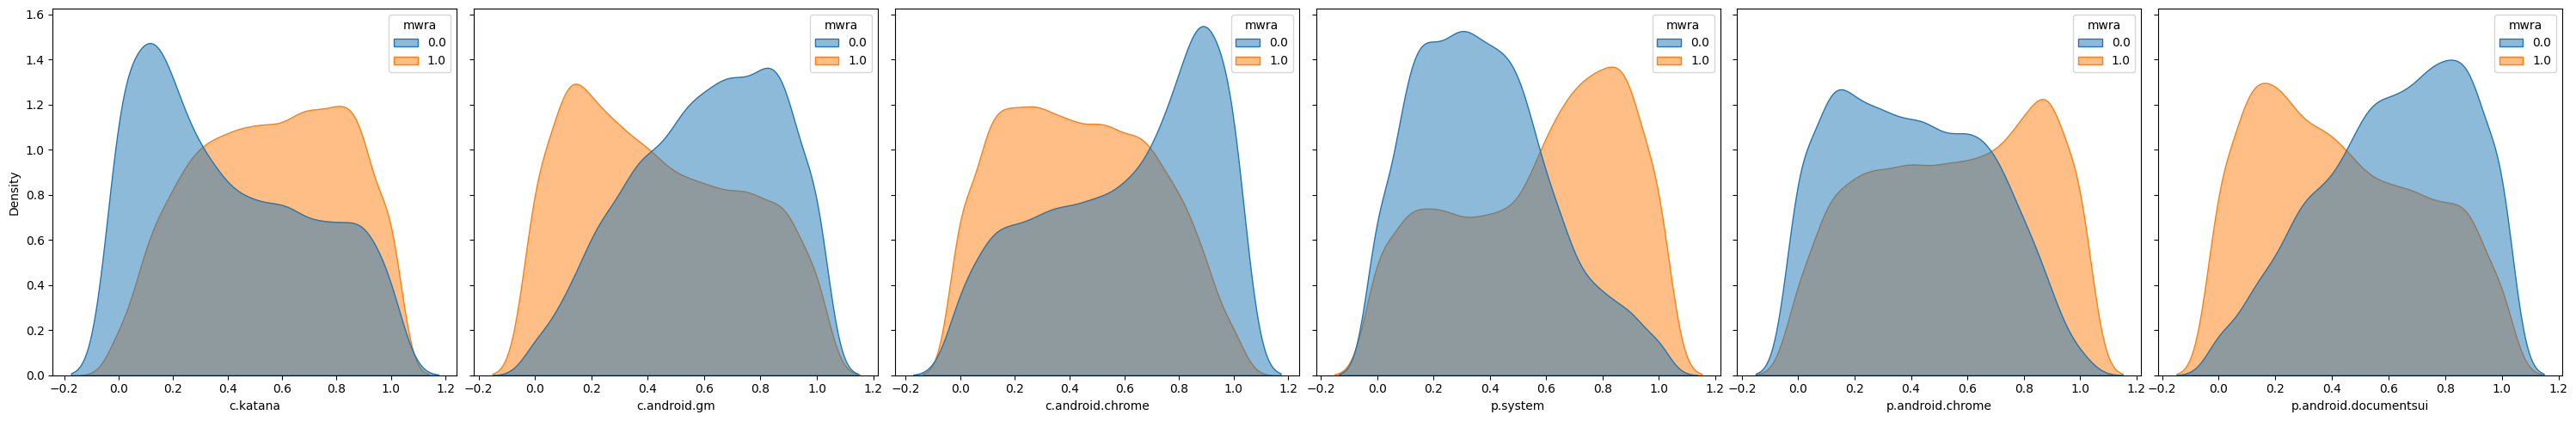

In [121]:
plot_predictor_distribution(X_train_robust_quantile, y_train, weak_predictors)

#### 2.1.D Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

In [122]:
X_train = X_train_normalized_power.copy()

Vyskúšali sme si viacej kombinácií škálovania a transformácií. Rozhodli sme sa, že ďalej (neskôr do pipeline) použijeme `MinMaxScaler` na škálovanie a `PowerTransformer` na transformovanie dát. Je to z dôvodu, že `MinMaxScaler` škáluje dáta na jednotný rozsah (v našom prípade <0; 1>). Používa sa, keď nemáme žiadnych outlierov alebo už boli odstránené, čo je presne náš prípad. Síce máme stále nejakých outlierov v premennej `p.browser.provider`, ale tá neni našim predikátorom, takže by to nemalo ovplyvňovať naše výsledky. `PowerTransformer` sme si vybrali pretože vie transofrmovať dáta približne na normálnu distribúciu (blízko normálnej distribúcii), čo je vhodné pre niektoré ML (Machine Learning) modely, pretože to môže prinášať lepšie výsledky.

### 2.2 Výber atribútov pre strojové učenie

#### 2.2.A Zistite, ktoré atribúty (features) vo vašich dátach pre ML sú informatívne k predikovanej premennej (minimálne 3 techniky s porovnaním medzi sebou). 

Vyskúšame 3 metódy na výber čŕt, ktoré nám pomôžu zistiť, ktoré črty (features) sú najinformatívnejšie pre predikciu našej predikovanej premennej `mwra`.

##### Mutual Information

In [123]:
mutual_info_regression_selector = SelectKBest(mutual_info_regression, k=5)
X_train_featured_mutual_info_regression = mutual_info_regression_selector.fit_transform(X_train, y_train)
X_train_featured_mutual_info_regression = pd.DataFrame(X_train_featured_mutual_info_regression, columns=X_train.columns[mutual_info_regression_selector.get_support()], index=X_train.index)

In [124]:
X_train_featured_mutual_info_regression.head(0)

,c.dogalize,p.system,p.android.gm,p.android.packageinstaller,p.browser.provider


##### F-value

In [125]:
f_regression_selector = SelectKBest(f_regression, k=5)
X_train_featured_f_regression = f_regression_selector.fit_transform(X_train, y_train)
X_train_featured_f_regression = pd.DataFrame(X_train_featured_f_regression, columns=X_train.columns[f_regression_selector.get_support()], index=X_train.index)

In [126]:
X_train_featured_f_regression.head(0)

,c.dogalize,p.system,p.android.gm,p.android.packageinstaller,p.browser.provider


##### Linear SVC(Support Vector Classifier)

In [127]:
lsvc_selector = SelectFromModel(LinearSVC(C=0.0001, penalty="l1", dual=False))
X_train_featured_lsvc = lsvc_selector.fit_transform(X_train, y_train)
X_train_featured_lsvc = pd.DataFrame(X_train_featured_lsvc, columns=X_train.columns[lsvc_selector.get_support()], index=X_train.index)

In [128]:
X_train_featured_lsvc.head(0)

,c.dogalize,p.android.gm,p.android.packageinstaller


#### 2.2.B Zoraďte zistené atribúty v poradí podľa dôležitosti. 

Taktiež vieme pomocou `Mutual Information` urobiť ranking našich čŕt (features) podľa dôležitosti.

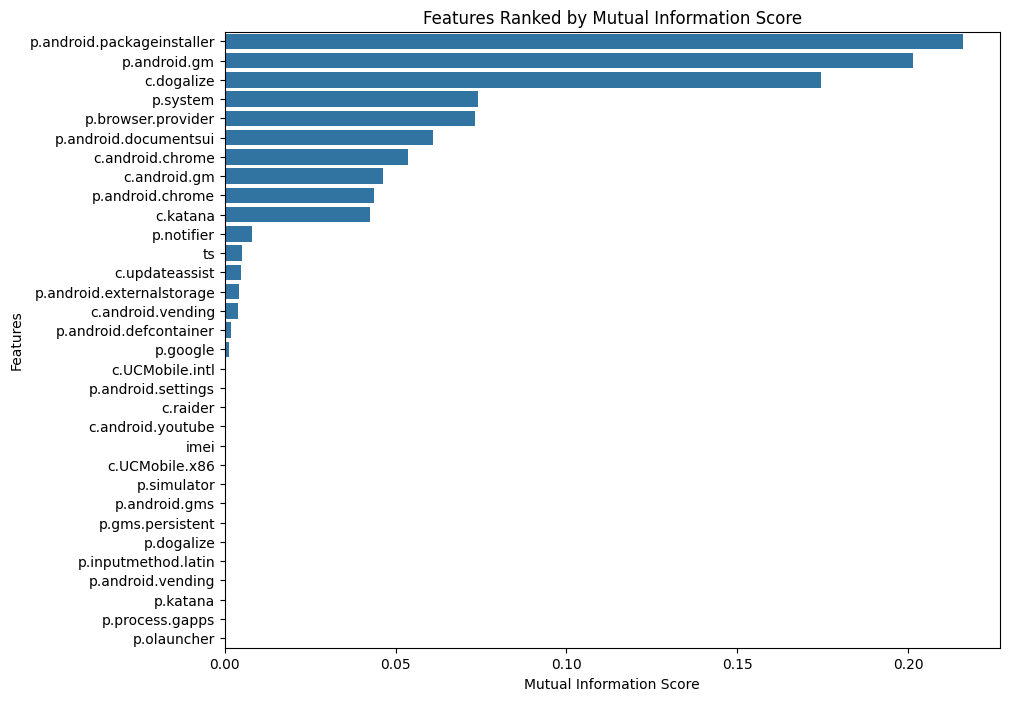

In [129]:
mutual_info_scores = mutual_info_regression_selector.scores_

feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Mutual Information Score': mutual_info_scores
})

feature_scores = feature_scores.sort_values(by='Mutual Information Score', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.barplot(x='Mutual Information Score', y='Feature', data=feature_scores)
plt.title("Features Ranked by Mutual Information Score")
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.show()


#### 2.2.C Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

Vyskúšali sme 3 metódy výberu čŕt (feature selection), a zisili sme, že nám dávajú totožné výsledky v zmysle nájdených "silných" čŕt (features).


Medzi ne patrí:
- c.dogalize
- p.system
- p.android.gm
- p.android.packageinstaller
- p.browser.provider

Tieto čŕty sú najinformatívnejšie pre predikovanie našej predikovanej premennej `mwra`.

V našom pipeline sme sa rozhodli, že použijeme metódu "Mutual Information" (`mutual_info_regression`) pre výber čŕt.

Metóda "Mutual information" meria závislosť medzi jednotlivými črtami a cieľovou (predikovanou) premennou bez toho, aby predpokladala konkrétny typ vzťahu medzi nimi (lineárny alebo nelineárny). Keďže sa jej výsledky aj zhodovali s ostatnými metódami, tak sme sa ju práve z tohto dôvodu rozhodli použiť v našom pipeline.

### 2.3 Replikovateľnosť predspracovania

#### 2.3.A Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny v kontexte strojového učenia.

##### Zrekapitulovanie toho, čo sme urobili manuálne bez "sklearn pipeline"

```py

df_connections = pd.read_csv('112/connections.csv', delimiter=',')
df_processes   = pd.read_csv('112/processes.csv', delimiter=',')

merged_data = df_connections.merge(df_processes, on=['imei', 'ts'], how='inner')
merged_data['ts'] = pd.to_numeric(pd.to_datetime(merged_data['ts'], errors='coerce'))
merged_data = merged_data.drop_duplicates()
merged_data = merged_data.drop(columns=['mwra_y'])
merged_data = merged_data.rename(columns={"mwra_x": "mwra"})

X = merged_data.drop(columns='mwra')
y = merged_data['mwra']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')
X_train_impute = imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train_impute, columns=X_train.columns, index=X_train.index)

X_train, y_train = handle_outliers(X_train, y_train)

min_max_scaler = MinMaxScaler()
X_train_normalized = min_max_scaler.fit_transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns, index=X_train.index)

power_transformer = PowerTransformer(method='yeo-johnson')
X_train_normalized_power = power_transformer.fit_transform(X_train_normalized)
X_train_normalized_power = pd.DataFrame(X_train_normalized_power, columns=X_train_normalized.columns, index=X_train_normalized.index)

X_train = X_train_normalized_power.copy()

mutual_info_regression_selector = SelectKBest(mutual_info_regression, k=5)
X_train_featured_mutual_info_regression = mutual_info_regression_selector.fit_transform(X_train, y_train)
X_train_featured_mutual_info_regression = pd.DataFrame(X_train_featured_mutual_info_regression, columns=X_train.columns[mutual_info_regression_selector.get_support()], index=X_train.index)

X_train = X_train_featured_mutual_info_regression.copy()
```

##### Vytvorenie pipeline

Vytvorenie vlastnej triedy na ošetrenie outlierov.

In [130]:
# co-engineered with ChatGPT
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.5, outlier_fraction=0.05):
        self.threshold = threshold
        self.outlier_fraction = outlier_fraction
        self.imputer = SimpleImputer(strategy='median')

    def fit(self, X, y=None):
        self.iqr = np.percentile(X, 75, axis=0) - np.percentile(X, 25, axis=0)
        self.lower_bound = np.percentile(X, 25, axis=0) - self.threshold * self.iqr
        self.upper_bound = np.percentile(X, 75, axis=0) + self.threshold * self.iqr
        return self

    def transform(self, X):
        outliers_mask = np.any((X < self.lower_bound) | (X > self.upper_bound), axis=1)
        num_outliers = np.sum(outliers_mask)
        total_samples = X.shape[0]
        outlier_fraction = num_outliers / total_samples
        
        if outlier_fraction < self.outlier_fraction:
            return X[~outliers_mask]
        else:
            X_imputed = X.copy()
            X_imputed[outliers_mask] = np.nan
            return self.imputer.fit_transform(X_imputed)
        # X_imputed = X.copy()
        # X_imputed[outliers_mask] = np.nan
        # return self.imputer.fit_transform(X_imputed)

Trieda `OutlierHandler` je akokeby vlastný transformer a vie transformovať vstupné dáta tak, že malé množstvo outlierov odstráni a veľké množstvo outlierov nahradí hraničnými hodnotami. Slúžia na to funkcie `fit` a `transform`.

- `fit()` - zistuje či sú záznamy obsahujú outlierov
- `transform()` - odstraňuje alebo nahradzuje outlierov

#### 2.3.B Využite možnosti sklearn.pipeline

Prevedenie celého nášho doterajšieho manuálneho postupu do "sklearn pipeline".

In [131]:
df_connections = pd.read_csv('112/connections.csv', delimiter=',')
df_processes = pd.read_csv('112/processes.csv', delimiter=',')

merged_data = df_connections.merge(df_processes, on=['imei', 'ts'], how='inner')
merged_data['ts'] = pd.to_numeric(pd.to_datetime(merged_data['ts'], errors='coerce'))
merged_data = merged_data.drop_duplicates()
merged_data = merged_data.drop(columns=['mwra_y'])
merged_data = merged_data.rename(columns={"mwra_x": "mwra"})

X = merged_data.drop(columns='mwra')
y = merged_data['mwra']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
preprocessor_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('outlier_handler', OutlierHandler(threshold=1.5, outlier_fraction=0.05)),
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('feature_selection', SelectKBest(mutual_info_regression, k=5))],
    verbose=True
)

preprocessor_pipeline.fit(X_train, y_train)

[Pipeline] ........... (step 1 of 5) Processing imputer, total=   0.0s
[Pipeline] ... (step 2 of 5) Processing outlier_handler, total=   0.1s
[Pipeline] ............ (step 3 of 5) Processing scaler, total=   0.0s
[Pipeline] . (step 4 of 5) Processing power_transformer, total=   0.4s
[Pipeline] . (step 5 of 5) Processing feature_selection, total=   2.9s


Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler', OutlierHandler()),
                ('scaler', MinMaxScaler()),
                ('power_transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_regression at 0x000002D99566A200>))],
         verbose=True)

Náš pipeline funguje nasledovne:
- `SimpleImputer` - nahradí chýbajúce hodnoty za priemer
- `OutlierHandler` - odstráni alebo nahradí outlierov
- `MinMaxScaler` - škáluje dáta na jednotný rozsah
- `PowerTransformer` - pokúsi sa transoformovať dáta na normálnu distribúciu (resp. distribúcie blízkej normálnej distribúcii)
- `SelectKBest` - vyberie najinformatívnejšie črty (features) pre predikciu predikovanej premennej (`mwra`)

In [133]:
preprocessed_train = preprocessor_pipeline.transform(X_train)
preprocessed_train = pd.DataFrame(preprocessed_train, columns=X_train.columns[preprocessor_pipeline.named_steps['feature_selection'].get_support()], index=X_train.index)

preprocessed_test = preprocessor_pipeline.transform(X_test)
preprocessed_test = pd.DataFrame(preprocessed_test, columns=X_test.columns[preprocessor_pipeline.named_steps['feature_selection'].get_support()], index=X_test.index)

Ukážka trénovacích a testovacích dát po prejdení cez pipeline.

In [134]:
preprocessed_train.head()

,c.dogalize,p.system,p.android.chrome,p.android.gm,p.android.packageinstaller
738,0.114386,-1.026912,1.553582,1.122762,-0.382006
7431,0.544525,-0.669475,-0.454100,-1.210283,1.092177
4588,-0.013582,-0.051539,-0.040255,0.026256,-0.024687
6235,-0.324938,1.775395,0.106666,0.148449,-0.507142
14123,-0.505895,1.881949,-0.105289,0.827570,-0.816568


In [135]:
preprocessed_test.head()

,c.dogalize,p.system,p.android.chrome,p.android.gm,p.android.packageinstaller
10335,-0.208588,-0.990860,0.371632,-1.505694,0.994537
14491,0.008674,-0.972365,1.158954,-0.109647,-0.783726
12851,-3.565067,-0.724099,0.487197,0.133880,-0.308383
3446,-0.516319,0.171753,0.618839,1.663613,-1.830938
2501,-0.051632,-0.039915,0.039671,-0.019123,-0.040675


Uloženie preprocesovaných dát do `.csv` súborov.

In [136]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

11957
11957
2990
2990


In [137]:
# pre_preprocess_train = X_train.copy()
# pre_preprocess_train = pre_preprocess_train[['c.dogalize']]
# pre_preprocess_train = pre_preprocess_train.drop(columns=['c.dogalize'])
# pre_preprocess_train["mwra"] = y_train
# pre_preprocess_train.to_csv('pre_preprocess_train.csv')
# pre_preprocess_test = X_test.copy()
# pre_preprocess_test = pre_preprocess_test[['c.dogalize']]
# pre_preprocess_test = pre_preprocess_test.drop(columns=['c.dogalize'])
# pre_preprocess_test["mwra"] = y_test
# pre_preprocess_test.to_csv('pre_preprocess_test.csv')

In [138]:
# preprocessed_train = preprocessed_train[['c.dogalize']]
# preprocessed_train = preprocessed_train.drop(columns=['c.dogalize'])

preprocessed_train["mwra"] = y_train
preprocessed_train.to_csv('preprocessed_train.csv', index=False)

In [139]:
# preprocessed_test = preprocessed_test[['c.dogalize']]
# preprocessed_test = preprocessed_test.drop(columns=['c.dogalize'])

preprocessed_test["mwra"] = y_test
preprocessed_test.to_csv('preprocessed_test.csv', index=False)

## Fáza 3 - Strojové učenie

<font color='salmon'>
    <b>Poznámka:</b>
    Toto je iba začiatok práce na fáze 3.
</font>

In [140]:
classifier_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_pipeline),
    ('classifier', DecisionTreeClassifier()),
])

In [141]:
classifier_pipeline.fit(X_train, y_train)

[Pipeline] ........... (step 1 of 5) Processing imputer, total=   0.0s
[Pipeline] ... (step 2 of 5) Processing outlier_handler, total=   0.1s
[Pipeline] ............ (step 3 of 5) Processing scaler, total=   0.0s
[Pipeline] . (step 4 of 5) Processing power_transformer, total=   0.3s
[Pipeline] . (step 5 of 5) Processing feature_selection, total=   2.8s


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('outlier_handler', OutlierHandler()),
                                 ('scaler', MinMaxScaler()),
                                 ('power_transformer', PowerTransformer()),
                                 ('feature_selection',
                                  SelectKBest(k=5,
                                              score_func=<function mutual_info_regression at 0x000002D99566A200>))],
                          verbose=True)),
                ('classifier', DecisionTreeClassifier())])

In [142]:
y_pred = classifier_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7809364548494984

Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.63      0.68      1116
         1.0       0.80      0.87      0.83      1874

    accuracy                           0.78      2990
   macro avg       0.77      0.75      0.76      2990
weighted avg       0.78      0.78      0.78      2990



Accuracy: 0.8411371237458194

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.71      0.77      1116
         1.0       0.84      0.92      0.88      1874

    accuracy                           0.84      2990
   macro avg       0.84      0.81      0.82      2990
weighted avg       0.84      0.84      0.84      2990



## Zdroje

**Fáza 1**

Prednášky a cvičenia z predmetu IAU.

[IAU Github repozitár](https://github.com/FIIT-IAU/IAU-course)

[Scipy dokumentácia](https://docs.scipy.org/doc/scipy/reference/index.html)

[Numpy dokumentácia](https://numpy.org/doc/)

[Pandas dokumentácia](https://pandas.pydata.org/docs/)

[Typical Analysis Procedure](https://work.thaslwanter.at/Stats/html/statsAnalysis.html)

**Fáza 2**

Predošlé zdroje plus:

[Scikit-learn dokumentácia](https://scikit-learn.org/1.5/api/index.html)

[Feature importance](https://machinelearningmastery.com/calculate-feature-importance-with-python/)

[Scaling](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/)

[Transformations](https://machinelearningmastery.com/power-transforms-with-scikit-learn/)